# PRÁCTICA 1 - APRENDIZAJE SUPERVISADO - PREPROCESADO

## 0. Indice
1. [Importación de Librerías, Lectura y Configuración](#11-importación-de-librerías-lectura-y-configuración)
2. [Entendimiento del DataFrame](#12-entendimiento-del-dataframe)
3. [Limpieza de los datos](#13-limpieza-de-los-datos)
    1. [Valores Nulos Numéricos](#131-valores-nulos-numericos)
    2. [Tratamiento de Columnas Nominales](#132-tratamiento-de-columnas-nominales)
        - [Tratamiento con Mapeo](#1321-tratamiento-por-mapeo)
        - [Tratamiento con OneHot-Encoding](#1322-tratamiento-con-onehot-encoding)
    3. [Tratamiento de Columnas Booleanas](#133-tratamiento-de-columnas-booleanas)
    4. [Tratamiento de Columnas DataTime](#134-tratamiento-de-columna-datatime)
4. [Combinación de Celdas por Cliente](#14-combinacion-de-celdas-por-cliente)
5. [Normalización de los Datos](#15-normalizacion-de-los-datos)
6. [Selección de Características](#16-seleccion-de-caracteristicas)
    1. [Filtro](#161-filtro)
        - [Chi^2](#1611-chi2)
        - [Mutual Information](#1612-mutual-information)
        - [Análisis de Varianza - ANOVA](#1613-analisis-de-varianza---anova)
    2. [Wrapper](#162-wrapper)
        - [RFE - Recursive Feature Eliminator](#1621-recursive-feature-eliminator-rfe)
        - [RFECV - Recursive Feature Eliminator With Cross Validation](#1622-recursive-deature-elimination-with-cross-validation-rfecv)
        - [SFS - Sequential Feature Selector](#1623-sequential-feature-selector-sfs)
    3. [Embebido](#163-embebido)
        - [Lasso](#1631-lasso)
        - [Ridge](#1632-ridge)
        - [ElasticNet](#1633-elasticnet)
7. [Tratamiento de los datos Desbalanceados](#17-tratamiento-de-los-datos-desbalanceados)
8. [Separación en Entrenamiento y Test](#18-separacion-en-entrenamiento-y-test)

## 1.1 Importación de Librerías, Lectura y Configuración

Vamos a importar todas las librerias que vamos a utilizar a lo largo del proyecto.<br>
Cada una está especificada para una función

In [4]:
# Librerías para manipulación de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Librerías para preprocesado de datos
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Librerías para selección de características
from sklearn.feature_selection import (
    SelectKBest, chi2, mutual_info_classif, f_classif, VarianceThreshold,
    RFE, RFECV, SequentialFeatureSelector
)

# Modelos de clasificación y regresión para selección de características y entrenamiento
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.ensemble import RandomForestClassifier

# Librerías para reducción de dimensionalidad
from sklearn.decomposition import PCA

# Librerías para tratamiento de datos desbalanceados
from imblearn.over_sampling import SMOTE

# Librerías para división de los datos
from sklearn.model_selection import train_test_split

En esta sección, cargamos el conjunto de datos de características de entrenamiento y las etiquetas correspondientes. Además, ajustamos la configuración de pandas para facilitar la visualización del dataset en este notebook.

- **Carga de datos**: 
  - Los datos de características (`train_data_0.csv`) y las etiquetas (`train_labels_0.csv`) se leen en dos DataFrames, `df` y `df_label`. 
  - `df` contiene las características de entrenamiento de los clientes, con 189 columnas que representan diferentes aspectos de las transacciones bancarias. 
  - `df_label` contiene las etiquetas de cada cliente, indicando si el cliente se convertirá en deudor o no, lo cual es nuestra variable objetivo.

In [5]:
# Carga de los datos de entrenamiento y etiquetas
df = pd.read_csv("./data/train_data.csv")
df_test = pd.read_csv("./data/test_data.csv")
df_label = pd.read_csv("./data/train_labels.csv")

- **Configuración de visualización**:
  - Ajustamos la configuración de pandas para mostrar todas las columnas y filas en las salidas del notebook, ya que al tener 189 características, el conjunto de datos sería difícil de visualizar en su totalidad con la configuración predeterminada.

In [6]:
# Configuración para visualizar todas las columnas y filas en el notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

- **Inspección inicial**: 
  - Mediante el uso de `head()`, mostramos las primeras filas de cada DataFrame para verificar que los datos se han cargado correctamente y entender mejor la estructura de cada conjunto.

In [7]:
df.head()

,ID,Expenditure_AHF,Payment_6804,Infraction_CGP,Base_7744,Base_80863,Risk_1930,Expenditure_JIG,Infraction_SNZ,Base_02683,Infraction_SBF,Infraction_ZWWJ,Infraction_QJJF,Base_76065,Infraction_EJZ,Base_6872,Risk_0322,Infraction_FMXQ,Infraction_GGO,Infraction_TLPJ,Infraction_NCB,Base_1165,Base_39598,Base_6187,Infraction_CLLY,Infraction_ZTNC,Base_85131,Risk_9995,Infraction_AYWV,Payment_22507,Base_9516,Infraction_GWL,Expenditure_YTR,Base_36384,Expenditure_FIP,Infraction_PAS,Risk_0003,Expenditure_HMO,Base_24406,Expenditure_LMSR,Infraction_BSU,Infraction_GEL,Base_14808,Risk_8065,Infraction_ZYW,Expenditure_KMW,Base_1039,Infraction_HSSU,Infraction_EHZP,Infraction_TBP,Base_0580,Expenditure_RGD,Infraction_PBC,Infraction_YFSG,Infraction_DQLY,Infraction_AQO,Base_0229,Base_8318,Base_69608,Base_91828,Infraction_HPS,Base_6852,Infraction_CLH,Expenditure_IDZ,Risk_1475,Expenditure_BWX,Base_8511,Infraction_JYZB,Base_22178,Infraction_ZTYG,Infraction_ZVW,Infraction_EYU,Expenditure_UWVG,Base_3041,Infraction_JVWF,Payment_3207,Infraction_QKZN,Infraction_CZE,Infraction_APIU,Base_65352,Risk_7095,Infraction_JBR,Base_66195,Base_36516,Infraction_RXQH,Infraction_HFU,Risk_6346,Risk_5797,Expenditure_HRQ,Infraction_VTR,Risk_2102,Risk_4804,Base_7331,Infraction_XWX,Infraction_FUSM,Expenditure_XDD,Risk_4553,Base_67585,Risk_8742,Infraction_VHU,Risk_4247,Risk_2380,Infraction_GSS,Risk_0454,Base_8379,Base_8730,Expenditure_HKXV,Infraction_MHM,Infraction_IRKE,Risk_4160,Risk_3506,Infraction_WEG,Base_23737,Expenditure_GCAO,Risk_9367,Base_7910,Expenditure_GMC,Risk_9423,Risk_6977,Base_9103,Infraction_KSBR,Risk_6178,Risk_6197,Infraction_NRBQ,Infraction_WVC,Infraction_QVSL,Infraction_QXUM,Risk_8532,Risk_9247,Infraction_IMIM,Expenditure_UIWS,Expenditure_ONEG,Expenditure_MTRQ,Expenditure_LAHK,Expenditure_HPM,Infraction_LTIS,Infraction_HFSI,Infraction_ETH,Infraction_ZVHJ,Infraction_ANHZ,Infraction_SDWM,Base_5441,Base_2810,Risk_4561,Risk_8902,Base_67254,Infraction_HPLO,Infraction_PTY,Infraction_QGC,Infraction_EBA,Base_64022,Infraction_BGGU,Base_4569,Expenditure_BEH,Infraction_LMHK,Infraction_NMCB,Infraction_TPAF,Infraction_ZRH,Infraction_TEN,Infraction_XEPQ,Infraction_ZMKI,Infraction_WIS,Infraction_RKTA,Infraction_IIZ,Infraction_WVAW,Infraction_KEJT,Infraction_TFOY,Infraction_WMAQ,Infraction_SIA,Infraction_CZXL,Infraction_QEY,Base_52892,Base_3958,Infraction_HUK,Infraction_VHHP,Infraction_WLMI,Infraction_LIES,Risk_5270,Infraction_SVKR,Infraction_MAN,Infraction_WWLN,Infraction_ADWZ,Infraction_MZI,Infraction_QWWW,Infraction_YQXM,Infraction_QGR,Infraction_ZTLC,Infraction_LSX,Infraction_IBJ,Infraction_DNOU
0,3333337004103300505242400473433643475477705348...,2017-03-05,0.929122,0.382790,0.025782,1.002647,0.005515,0.089799,0.001479,0.005830,NaN,NaN,0.009873,0.021776,0.239459,0.070967,0.008058,0.457826,0.382562,0.059342,NaN,0.201574,0.032390,0.007684,NaN,0.334386,0.007561,0.005552,0.110471,0.619012,0.302757,NaN,0.025802,0.011677,0.003243,1.009099,0.001485,0.072583,0.026337,0.596242,0.052813,0.684371,0.036490,0.004105,0.007069,NaN,0.015918,0.230700,0.375191,0.063612,0.005119,0.281806,0.239244,CO,O,0.007912,0.174382,NaN,1.008107,0.001015,NaN,0.002688,very_high,0.175123,0.000396,0.282619,0.006760,0.006521,0.007803,0.001396,0.015735,0.002945,0.200131,0.014834,NaN,0.004637,0.000560,0.000939,NaN,0.000798,0.000963,0.222324,0.027022,0.005833,0.002569,0.000223,0.009420,NaN,0.001228,0.008212,0.000954,0.008326,0.002704,0.002767,NaN,0.000797,1.002751,0.020552,0.007203,0.002874,0.001399,0.003912,0.004593,0.004460,NaN,0.0,0.003757,0.002582,NaN,0.007083,0.004040,NaN,1,0.002157,0.009864,0.005578,0.008184,NaN,0.003199,1.006756,0.009185,0.000482,0.004166,0.007530,0.000142,0.005410,0.008460,0.001500,0.004736,0.001770,0.914921,0.135440,0.926104,0.976465,0.006042,0.001040,0.007944,0.007099,NaN,NaN,0.007600,0.005126,0.023904,NaN,1.003868,moderate_low,NaN,0.009713,NaN,NaN,NaN,1.008423,0.030687,NaN,0.005897,1.0,0.430118,0.0,extremely_low,0.418370,0.416349,0.0,0.527146,0.292568,0.009932,0.137895,0.009582,1.0,0.0

In [8]:
df_label.head()

,ID,label
0,3333337004103300505242400473433643475477705348...,0
1,3333412724050477534287115505554450368233003786...,0
2,3333755354307801420025735367852078550468735254...,0
3,3333545238615133608512002405572210535308150267...,0
4,3333333216773173414240337455254307444633113087...,1


Esta configuración es clave para familiarizarnos con los datos y preparar el análisis exploratorio inicial.

## 1.2 Entendimiento del DataFrame

[Volver al Indice](#0-indice)

En esta sección, exploraremos el contenido del DataFrame `df`, que contiene las características de las transacciones de los clientes, y `df_label`, que contiene las etiquetas de deudores. El propósito de esta inspección inicial es identificar la estructura del dataset, tipos de datos, presencia de valores nulos, y estadísticas básicas que nos ayuden a comprender las características que tenemos y su distribución.


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3318787 entries, 0 to 3318786
Columns: 190 entries, ID to Infraction_DNOU
dtypes: float64(182), int64(1), object(7)
memory usage: 4.7+ GB


Vamos a analizar el restultado del comando `df.info()`:
- **Número de filas**: El DataFrame contiene **3,318,787 filas**, lo que indica que hay una gran cantidad de datos, probablemente uno por transacción o cliente.
- **Número de columnas**: El DataFrame tiene **190 columnas**, lo cual confirma la alta dimensionalidad del dataset.
- **Tipos de datos**:
  - **float64**: La mayoría de las columnas (182) son de tipo `float64`, indicando que contienen datos numéricos decimales.
  - **int64**: Hay una columna de tipo `int64`,que posiblemente sea un conteo.
  - **object**: Siete columnas son de tipo `object`, lo cual puede indicar datos categóricos o texto, que probablemente requerirán un preprocesado específico más adelante.

Utilizamos `df.describe(include="object")` para obtener un resumen estadístico de las columnas categóricas del DataFrame. Este método nos proporciona una visión general de las columnas de tipo `object`, que normalmente contienen datos categóricos o de texto, y es especialmente útil para entender la distribución de valores únicos en estas columnas.

In [10]:
df.describe(include="object")

,ID,Expenditure_AHF,Infraction_YFSG,Infraction_DQLY,Infraction_CLH,Base_67254,Infraction_TEN
count,3318787,3318787,3318787,3188123,3188733,3317538,3212364
unique,275347,401,6,4,7,7,7
top,3333337004103300505242400473433643475477705348...,2018-02-18,CO,O,very_high,moderate_low,extremely_low
freq,13,11480,2473189,1748616,1667728,1174012,871883


Revisamos las principales columnas categóricas para entender su contenido y planificar su tratamiento en el preprocesado. A continuación, resumimos nuestras observaciones y acciones propuestas para cada columna.

1. **ID**
- Representa un identificador único por transacción o cliente, con solo *275,347 valores únicos* en más de *3 millones de filas*, lo que indica múltiples transacciones por cliente.
- **Posible acción**: Como es un simple identificador, podríamos eliminar esta columna, ya que no aporta valor predictivo.

2. **Expenditure_AHF**
- Parece contener *fechas* asociadas a categorías de gasto, lo que podría ser útil para capturar patrones temporales.
- **Posible acción**: Si confirmamos que son fechas, extraeríamos características como año, mes o día de la semana, o bien agruparíamos en períodos como trimestres si fuera más adecuado.

3. **Infraction_YFSG, Infraction_DQLY, Infraction_CLH, Base_67254, Infraction_TEN**
- Estas columnas parecen indicar tipos o niveles de infracción con *pocos valores únicos*.
- **Posible acción**: Usaríamos **OneHot-Encoding** o **Label Encoding** para convertirlas en variables numéricas. Si alguna categoría estuviera desbalanceada, podríamos agrupar categorías menos frecuentes.


Una vez hemos analizado las variables tipo `object` vamos a analizar las variables tipo `number` para ver si podemos sacar alguna conclusión en claro

In [11]:
df.describe()

,Payment_6804,Infraction_CGP,Base_7744,Base_80863,Risk_1930,Expenditure_JIG,Infraction_SNZ,Base_02683,Infraction_SBF,Infraction_ZWWJ,Infraction_QJJF,Base_76065,Infraction_EJZ,Base_6872,Risk_0322,Infraction_FMXQ,Infraction_GGO,Infraction_TLPJ,Infraction_NCB,Base_1165,Base_39598,Base_6187,Infraction_CLLY,Infraction_ZTNC,Base_85131,Risk_9995,Infraction_AYWV,Payment_22507,Base_9516,Infraction_GWL,Expenditure_YTR,Base_36384,Expenditure_FIP,Infraction_PAS,Risk_0003,Expenditure_HMO,Base_24406,Expenditure_LMSR,Infraction_BSU,Infraction_GEL,Base_14808,Risk_8065,Infraction_ZYW,Expenditure_KMW,Base_1039,Infraction_HSSU,Infraction_EHZP,Infraction_TBP,Base_0580,Expenditure_RGD,Infraction_PBC,Infraction_AQO,Base_0229,Base_8318,Base_69608,Base_91828,Infraction_HPS,Base_6852,Expenditure_IDZ,Risk_1475,Expenditure_BWX,Base_8511,Infraction_JYZB,Base_22178,Infraction_ZTYG,Infraction_ZVW,Infraction_EYU,Expenditure_UWVG,Base_3041,Infraction_JVWF,Payment_3207,Infraction_QKZN,Infraction_CZE,Infraction_APIU,Base_65352,Risk_7095,Infraction_JBR,Base_66195,Base_36516,Infraction_RXQH,Infraction_HFU,Risk_6346,Risk_5797,Expenditure_HRQ,Infraction_VTR,Risk_2102,Risk_4804,Base_7331,Infraction_XWX,Infraction_FUSM,Expenditure_XDD,Risk_4553,Base_67585,Risk_8742,Infraction_VHU,Risk_4247,Risk_2380,Infraction_GSS,Risk_0454,Base_8379,Base_8730,Expenditure_HKXV,Infraction_MHM,Infraction_IRKE,Risk_4160,Risk_3506,Infraction_WEG,Base_23737,Expenditure_GCAO,Risk_9367,Base_7910,Expenditure_GMC,Risk_9423,Risk_6977,Base_9103,Infraction_KSBR,Risk_6178,Risk_6197,Infraction_NRBQ,Infraction_WVC,Infraction_QVSL,Infraction_QXUM,Risk_8532,Risk_9247,Infraction_IMIM,Expenditure_UIWS,Expenditure_ONEG,Expenditure_MTRQ,Expenditure_LAHK,Expenditure_HPM,Infraction_LTIS,Infraction_HFSI,Infraction_ETH,Infraction_ZVHJ,Infraction_ANHZ,Infraction_SDWM,Base_5441,Base_2810,Risk_4561,Risk_8902,Infraction_HPLO,Infraction_PTY,Infraction_QGC,Infraction_EBA,Base_64022,Infraction_BGGU,Base_4569,Expenditure_BEH,Infraction_LMHK,Infraction_NMCB,Infraction_TPAF,Infraction_ZRH,Infraction_XEPQ,Infraction_ZMKI,Infraction_WIS,Infraction_RKTA,Infraction_IIZ,Infraction_WVAW,Infraction_KEJT,Infraction_TFOY,Infraction_WMAQ,Infraction_SIA,Infraction_CZXL,Infraction_QEY,Base_52892,Base_3958,Infraction_HUK,Infraction_VHHP,Infraction_WLMI,Infraction_LIES,Risk_5270,Infraction_SVKR,Infraction_MAN,Infraction_WWLN,Infraction_ADWZ,Infraction_MZI,Infraction_QWWW,Infraction_YQXM,Infraction_QGR,Infraction_ZTLC,Infraction_LSX,Infraction_IBJ,Infraction_DNOU
count,3.291306e+06,3.318787e+06,3.318787e+06,3.317538e+06,3.318787e+06,2.708814e+06,3.317538e+06,3.317538e+06,477408.000000,2.321974e+06,3.154027e+06,3.318787e+06,3.317538e+06,3.318787e+06,3.318787e+06,2.592299e+06,3.318787e+06,2.888970e+06,3.289380e+05,3.318635e+06,3.318787e+06,3.305442e+06,1.434881e+06,3.318787e+06,3.318787e+06,3.318787e+06,3.301204e+06,3.137247e+06,3.318787e+06,8.694400e+05,3.318787e+06,3.318787e+06,3.318787e+06,3.317538e+06,3.318787e+06,2.708814e+06,3.318787e+06,3.318787e+06,3.207940e+06,1.527953e+06,3.288880e+06,3.318787e+06,3.318787e+06,1.561420e+06,3.318787e+06,3.254505e+06,3.318787e+06,2.960477e+06,3.314665e+06,3.318787e+06,2.865010e+06,3.318787e+06,3.317538e+06,1.435516e+06,3.318787e+06,3.317538e+06,374682.000000,3.317538e+06,3.318787e+06,3.318787e+06,3.318787e+06,3.318787e+06,3.201912e+06,3.317538e+06,3.261590e+06,3.318787e+06,3.304680e+06,3.318787e+06,3.318787e+06,33563.000000,3.318787e+06,3.305588e+06,3.318787e+06,3.744470e+05,3.318787e+06,3.318786e+06,1.808788e+06,3.314665e+06,3.317538e+06,3.154027e+06,3.273095e+06,3.318787e+06,1.876450e+05,3.318787e+06,3.305588e+06,3.318787e+06,3.318787e+06,3.317538e+06,3.303458e+06,8.818820e+05,3.318787e+06,3.318763e+06,3.318787e+06,3.318787e+06,3.201912e+06,3.318786e+06,3.318787e+06,3.301204e+06,3.318787e+06,2.275660e+05,3.317538e+06,3.318787e+06,3.318787e+06,2318.0,3.318787e+06,3.318787e+06,3585.000000,3.318787e+06,3.318787e+06,3.318787e+06,3.318787e+06,3.318787e+06,3.318748e+06,3.318787e+06,3.317538e+06,3

Analizando las columnas numéricas, observamos que hay cinco tipos principales de datos que se repiten con distintos identificadores: `Payment`, `Infraction`, `Base`, `Risk` y `Expenditure`.

 A continuación, dividiremos estas categorías en diferentes DataFrames para analizarlas en conjunto y comprender mejor las características compartidas dentro de cada grupo

In [12]:
# Seleccionar solo las columnas que contienen 'Infraction' en su nombre
df_infractions = df.filter(regex='Infraction')

# aqui muestro la dimension del dataframe para ver las columnas dedicadas a 
# 'infractions'
print(df_infractions.shape)

# Mostrar las primeras filas para verificar el resultado
df_infractions.head()

(3318787, 96)


,Infraction_CGP,Infraction_SNZ,Infraction_SBF,Infraction_ZWWJ,Infraction_QJJF,Infraction_EJZ,Infraction_FMXQ,Infraction_GGO,Infraction_TLPJ,Infraction_NCB,Infraction_CLLY,Infraction_ZTNC,Infraction_AYWV,Infraction_GWL,Infraction_PAS,Infraction_BSU,Infraction_GEL,Infraction_ZYW,Infraction_HSSU,Infraction_EHZP,Infraction_TBP,Infraction_PBC,Infraction_YFSG,Infraction_DQLY,Infraction_AQO,Infraction_HPS,Infraction_CLH,Infraction_JYZB,Infraction_ZTYG,Infraction_ZVW,Infraction_EYU,Infraction_JVWF,Infraction_QKZN,Infraction_CZE,Infraction_APIU,Infraction_JBR,Infraction_RXQH,Infraction_HFU,Infraction_VTR,Infraction_XWX,Infraction_FUSM,Infraction_VHU,Infraction_GSS,Infraction_MHM,Infraction_IRKE,Infraction_WEG,Infraction_KSBR,Infraction_NRBQ,Infraction_WVC,Infraction_QVSL,Infraction_QXUM,Infraction_IMIM,Infraction_LTIS,Infraction_HFSI,Infraction_ETH,Infraction_ZVHJ,Infraction_ANHZ,Infraction_SDWM,Infraction_HPLO,Infraction_PTY,Infraction_QGC,Infraction_EBA,Infraction_BGGU,Infraction_LMHK,Infraction_NMCB,Infraction_TPAF,Infraction_ZRH,Infraction_TEN,Infraction_XEPQ,Infraction_ZMKI,Infraction_WIS,Infraction_RKTA,Infraction_IIZ,Infraction_WVAW,Infraction_KEJT,Infraction_TFOY,Infraction_WMAQ,Infraction_SIA,Infraction_CZXL,Infraction_QEY,Infraction_HUK,Infraction_VHHP,Infraction_WLMI,Infraction_LIES,Infraction_SVKR,Infraction_MAN,Infraction_WWLN,Infraction_ADWZ,Infraction_MZI,Infraction_QWWW,Infraction_YQXM,Infraction_QGR,Infraction_ZTLC,Infraction_LSX,Infraction_IBJ,Infraction_DNOU
0,0.382790,0.001479,NaN,NaN,0.009873,0.239459,0.457826,0.382562,0.059342,NaN,NaN,0.334386,0.110471,NaN,1.009099,0.052813,0.684371,0.007069,0.230700,0.375191,0.063612,0.239244,CO,O,0.007912,NaN,very_high,0.006521,0.001396,0.015735,0.002945,NaN,0.000560,0.000939,NaN,0.222324,0.002569,0.000223,0.008212,0.002767,NaN,0.002874,0.004593,0.002582,NaN,NaN,0.009185,0.007530,0.000142,0.005410,0.008460,0.001770,0.001040,0.007944,0.007099,NaN,NaN,0.007600,NaN,0.009713,NaN,NaN,1.008423,0.005897,1.0,0.430118,0.0,extremely_low,0.418370,0.416349,0.0,0.527146,0.292568,0.009932,0.137895,0.009582,1.0,0.008318,1.002662,0.003712,0.002148,0.003912,NaN,0.001289,NaN,NaN,NaN,NaN,NaN,0.003776,0.001808,0.008200,NaN,0.001061,0.000027,0.002629
1,0.002224,0.007831,NaN,NaN,0.007450,0.247009,0.462680,0.386114,0.083383,NaN,NaN,0.672143,0.105637,NaN,1.008566,0.060770,0.689035,0.004691,0.231395,0.295413,0.079257,0.237756,CO,O,0.006940,NaN,very_high,0.006329,0.003582,0.009996,0.009189,NaN,0.007647,0.001021,NaN,0.220491,0.002954,0.001704,0.008214,0.000363,NaN,0.006453,0.000343,0.009929,NaN,NaN,0.004663,0.504566,0.006717,0.005985,0.009168,0.004741,0.009589,0.000881,0.007604,NaN,NaN,0.003800,NaN,0.008126,NaN,NaN,1.006873,0.001209,1.0,0.435939,0.0,extremely_low,0.426850,0.423039,1.0,0.534687,0.294283,0.007077,0.138047,0.006469,1.0,0.000664,1.004011,0.002510,0.003031,0.000364,NaN,0.001774,NaN,NaN,NaN,NaN,NaN,0.004046,0.008288,0.001375,NaN,0.009999,0.002669,0.006912
2,0.567403,0.003162,NaN,NaN,0.004221,0.243067,0.450481,0.384930,0.086904,NaN,NaN,0.666925,0.104565,NaN,1.001835,0.059962,0.717729,0.006135,0.237276,0.446750,0.081170,0.241097,CO,O,0.004088,NaN,very_high,0.008677,0.005807,0.014169,0.002116,NaN,0.002825,0.007836,NaN,0.225580,0.005302,0.004873,0.001601,0.001754,NaN,0.008809,0.002477,0.006179,NaN,NaN,0.002092,0.504338,0.008126,0.000546,0.002066,0.009971,0.008368,0.000075,0.001325,NaN,NaN,0.006165,NaN,0.009368,NaN,NaN,1.007557,0.009670,1.0,0.430128,0.0,extremely_low,0.431973,0.428164,1.0,0.534194,0.288778,0.004586,0.140566,0.001776,1.0,0.002105,1.003222,0.006578,0.002805,0.001707,NaN,0.001329,NaN,NaN,NaN,NaN,NaN,0.007742,0.002693,0.009851,NaN,0.000996,0.003254,0.004469
3,0.213193,0.009513,NaN,NaN,0.001658,0.254167,0.442022,0.389402,0.036248,NaN,NaN,0.340447,0.110119,NaN,1.006224,0.052496,0.717408,0.005296,0.232312,0.333445,0.026943,0.234295,CO,O,0.000637,NaN,very_high,0.002172,0.000447,0.008914,0.009095,NaN,0.006569,0.006118,NaN,0.225211,0.001896,0.007871,0.004777,0.009552,NaN,0.002159,0.003820,0.0

El DataFrame `df_infractions` contiene exclusivamente columnas relacionadas con datos de infracciones. A continuación se ofrece una visión general de las características de este DataFrame:

- **Dimensiones del DataFrame**: `(3,318,787, 96)`, lo cual indica que tenemos un total de 3,318,787 registros (filas) y 96 columnas correspondientes a diferentes tipos de infracciones.
  
- **Columnas de Infracciones**: Cada columna representa una categoría o tipo de infracción específica. Los nombres de las columnas incluyen identificadores únicos (por ejemplo, `Infraction_CGP`, `Infraction_SNZ`, etc.), lo que permite una diferenciación clara entre los distintos tipos de infracciones.

Estructura y Tipos de Datos

- **Valores Numéricos y Categóricos**: La mayoría de las columnas de infracciones contienen valores numéricos continuos, los cuales pueden representar la gravedad o frecuencia de cada tipo de infracción. Sin embargo, en algunas columnas se observan valores categóricos, como `"extremely_low"` o `"very_high"`, que probablemente representan categorías de riesgo o severidad.

- **Valores Faltantes**: Es común encontrar valores nulos (`NaN`) en algunas columnas. Esto puede indicar que ciertos tipos de infracciones no aplican a todos los registros, o que la información sobre esas infracciones está incompleta para algunas entradas.


In [13]:
# Seleccionar solo las columnas que contienen 'Expenditure' en su nombre
df_expenditure = df.filter(regex='Expenditure')

# aqui muestro la dimension del dataframe para ver las columnas dedicadas a 
# 'expenditure'
print(df_expenditure.shape)

# Mostrar las primeras filas para verificar el resultado
df_expenditure.head()

(3318787, 22)


,Expenditure_AHF,Expenditure_JIG,Expenditure_YTR,Expenditure_FIP,Expenditure_HMO,Expenditure_LMSR,Expenditure_KMW,Expenditure_RGD,Expenditure_IDZ,Expenditure_BWX,Expenditure_UWVG,Expenditure_HRQ,Expenditure_XDD,Expenditure_HKXV,Expenditure_GCAO,Expenditure_GMC,Expenditure_UIWS,Expenditure_ONEG,Expenditure_MTRQ,Expenditure_LAHK,Expenditure_HPM,Expenditure_BEH
0,2017-03-05,0.089799,0.025802,0.003243,0.072583,0.596242,NaN,0.281806,0.175123,0.282619,0.200131,0.001228,0.000797,0.003757,0.002157,0.008184,0.914921,0.135440,0.926104,0.976465,0.006042,NaN
1,2017-04-20,0.095966,0.004938,0.006905,0.081383,0.472848,0.006782,0.368255,0.133366,0.006044,0.205070,0.003258,0.003771,0.001069,0.008078,0.005347,0.886502,0.133348,0.894015,0.976638,0.005882,0.317246
2,2017-05-11,0.094655,0.011832,0.007552,0.083990,0.666716,NaN,0.408506,0.181359,0.428290,0.208094,0.003000,0.002065,0.006893,0.000952,0.002703,0.939467,0.133085,0.934993,0.978863,0.001987,0.005694
3,2017-06-29,0.099089,0.036272,0.000044,0.081560,0.762724,NaN,0.282240,0.344811,0.282940,0.101021,0.007752,0.007113,0.009890,0.005835,0.008242,0.913676,0.132812,0.918448,0.975971,0.007262,0.002922
4,2017-08-03,0.108526,0.052949,0.004738,0.094930,0.763803,0.007432,0.209741,0.175933,0.286403,0.100353,0.001394,0.009012,0.002780,0.006392,0.006672,0.947045,0.136809,0.960283,0.974565,0.001130,0.341470


El DataFrame `df_expenditure` contiene exclusivamente columnas relacionadas con datos de gasto. Este subconjunto del conjunto de datos general tiene una estructura específica:

- **Dimensiones del DataFrame**: `(3,318,787, 22)`, lo que indica que cuenta con 3,318,787 registros (filas) y 22 columnas dedicadas a diferentes categorías de gasto.
  
- **Columnas de Gastos**: Cada columna representa una categoría o tipo específico de gasto, identificadas por etiquetas como `Expenditure_AHF`, `Expenditure_JIG`, etc. Esto permite un análisis detallado de las distintas partidas de gasto en el conjunto de datos.

Estructura y Tipos de Datos

- **Valores Numéricos y de Fechas**: La mayoría de las columnas de gastos contienen valores numéricos continuos, lo que probablemente represente montos en alguna unidad de medida. Sin embargo, se observa que algunas columnas, como `Expenditure_AHF`, contienen fechas que podrían indicar el momento de registro de los gastos o de la última actualización de dichos datos.

- **Valores Faltantes**: En ciertas columnas hay valores nulos (`NaN`), lo cual puede deberse a la falta de información para ciertas categorías de gasto en algunos registros. Este aspecto debe considerarse al analizar la coherencia y completitud de los datos.


In [14]:
# Seleccionar solo las columnas que contienen 'Risk' en su nombre
df_risk = df.filter(regex='Risk')

# aqui muestro la dimension del dataframe para ver las columnas dedicadas a 
# 'Risk'
print(df_risk.shape)

# Mostrar las primeras filas para verificar el resultado
df_risk.head()


(3318787, 28)


,Risk_1930,Risk_0322,Risk_9995,Risk_0003,Risk_8065,Risk_1475,Risk_7095,Risk_6346,Risk_5797,Risk_2102,Risk_4804,Risk_4553,Risk_8742,Risk_4247,Risk_2380,Risk_0454,Risk_4160,Risk_3506,Risk_9367,Risk_9423,Risk_6977,Risk_6178,Risk_6197,Risk_8532,Risk_9247,Risk_4561,Risk_8902,Risk_5270
0,0.005515,0.008058,0.005552,0.001485,0.004105,0.000396,0.000963,0.009420,NaN,0.000954,0.008326,1.002751,0.007203,0.001399,0.003912,0.004460,0.007083,0.004040,0.009864,NaN,0.003199,0.000482,0.004166,0.001500,0.004736,NaN,1.003868,0.003198
1,0.003287,0.006785,0.001319,0.000638,0.000791,0.004131,0.001982,0.003919,NaN,0.004326,0.001358,1.006914,0.001203,0.009384,0.009396,0.002898,0.007837,0.003902,0.004189,0.000296,0.003957,0.000256,0.009724,0.009940,0.009356,NaN,1.001694,0.009974
2,0.005594,0.008117,0.002729,0.004912,0.005254,0.004799,0.003067,0.005586,NaN,0.007756,0.004264,1.005440,0.002608,0.005944,0.000371,0.002720,0.008268,0.001903,0.001200,0.003717,0.009305,0.003114,0.001053,0.006077,0.003896,NaN,1.002329,0.002501
3,0.008996,0.007326,0.008935,0.003507,0.004414,0.001317,0.009390,0.004440,NaN,0.008919,0.004406,1.008088,0.006692,0.007051,0.006375,0.005186,0.003785,0.009991,0.001468,0.003763,0.006923,0.002302,0.004728,0.000317,0.007030,NaN,1.009615,0.006614
4,0.008041,0.009446,0.002589,0.000154,0.007880,0.008271,0.005445,0.007108,NaN,0.004627,0.009922,1.002697,0.008732,0.000852,0.009575,0.004130,0.002932,0.001728,0.006513,0.001468,0.005330,0.008732,0.002751,0.004381,0.000662,NaN,1.005002,0.003082


El DataFrame `df_risk` contiene exclusivamente columnas relacionadas con datos de riesgo. Este subconjunto tiene características que permiten analizar los niveles de riesgo asociados a diferentes identificadores específicos.

- **Dimensiones del DataFrame**: `(3,318,787, 28)`, lo cual indica que contiene 3,318,787 registros (filas) y 28 columnas dedicadas a diferentes tipos de riesgo.

- **Columnas de Riesgo**: Cada columna representa un tipo o categoría específica de riesgo, con etiquetas como `Risk_1930`, `Risk_0322`, etc. Esto sugiere un sistema amplio para clasificar los riesgos, probablemente vinculados a diferentes factores o identificadores únicos.

Estructura y Tipos de Datos

- **Valores Numéricos Continuos**: Las columnas de riesgo contienen principalmente valores numéricos continuos. Estos valores podrían representar puntuaciones, probabilidades o índices de riesgo.

- **Valores Faltantes**: Algunas columnas presentan valores nulos (`NaN`), lo cual podría indicar que ciertos tipos de riesgo no son aplicables o no fueron medidos para algunos registros. Este aspecto es importante al analizar la consistencia y completitud de los datos y al decidir cómo manejar estos valores.


In [15]:
# Seleccionar solo las columnas que contienen 'Base' en su nombre
df_base = df.filter(regex='Base')

# aqui muestro la dimension del dataframe para ver las columnas dedicadas a 
# 'base'
print(df_base.shape)

# Mostrar las primeras filas y primeras columnas para verificar el resultado
df_base.iloc[:5, :10]

(3318787, 40)


,Base_7744,Base_80863,Base_02683,Base_76065,Base_6872,Base_1165,Base_39598,Base_6187,Base_85131,Base_9516
0,0.025782,1.002647,0.005830,0.021776,0.070967,0.201574,0.032390,0.007684,0.007561,0.302757
1,0.006806,1.008186,0.000861,0.012991,0.026492,0.202135,0.024356,0.003301,0.004459,0.295964
2,0.033713,1.007497,0.010466,0.015447,0.031776,0.191490,0.034360,0.006907,0.010246,0.296058
3,0.031170,1.008534,0.005360,0.015686,0.057811,0.199848,0.028317,0.008251,0.010398,0.294000
4,0.109644,1.005098,0.005484,0.046556,0.029022,0.226641,0.068204,0.000402,0.045093,0.301472


El DataFrame `df_base` contiene exclusivamente columnas relacionadas con datos "Base". Este subconjunto permite analizar distintas variables base que parecen reflejar valores numéricos fundamentales asociados a cada registro.

- **Dimensiones del DataFrame**: `(3,318,787, 40)`, lo cual indica que contiene 3,318,787 registros (filas) y 40 columnas dedicadas a diferentes tipos de datos base.

- **Columnas de Base**: Cada columna representa una variable base específica, con nombres como `Base_7744`, `Base_80863`, etc. Estos nombres sugieren un sistema de categorización amplio, posiblemente vinculado a distintos identificadores o índices específicos.

Estructura y Tipos de Datos

- **Valores Numéricos Continuos**: Las columnas de base contienen principalmente valores numéricos continuos, que podrían representar índices, métricas normalizadas o medidas específicas de cada registro.
  
- **Valores Faltantes**: No se observan valores nulos en la muestra inicial de las primeras filas y columnas, aunque se requiere una revisión exhaustiva para confirmar la ausencia o presencia de datos faltantes en todo el DataFrame.



In [16]:
# Seleccionar solo las columnas que contienen 'Payment' en su nombre
df_payment = df.filter(regex='Payment')

# aqui muestro la dimension del dataframe para ver las columnas dedicadas a 
# 'payment'
print(df_payment.shape)

# Mostrar las primeras filas para verificar el resultado
df_payment.head()

(3318787, 3)


,Payment_6804,Payment_22507,Payment_3207
0,0.929122,0.619012,0.004637
1,0.918431,0.591144,0.009077
2,0.922563,0.597797,0.003788
3,0.919253,0.610275,0.003013
4,0.901860,0.566030,0.008953


El DataFrame `df_payment` contiene exclusivamente columnas relacionadas con datos de pagos. Este subconjunto facilita el análisis de los datos de pago asociados a cada registro, brindando información potencialmente valiosa sobre transacciones o montos de pagos específicos.

- **Dimensiones del DataFrame**: `(3,318,787, 3)`, lo cual indica que contiene 3,318,787 registros (filas) y 3 columnas dedicadas a diferentes tipos de pagos.

- **Columnas de Pagos**: Cada columna representa una categoría de pago específica, con etiquetas como `Payment_6804`, `Payment_22507`, etc. Esto sugiere un sistema para clasificar distintos tipos de pagos, posiblemente relacionados con diferentes medios, periodos o categorías de transacción.

Estructura y Tipos de Datos

- **Valores Numéricos Continuos**: Las columnas de pago contienen valores numéricos continuos, que podrían indicar montos en una moneda específica o algún tipo de índice de pago.

- **Valores Completos**: No se observan valores nulos (`NaN`) en la muestra inicial, aunque se recomienda una revisión exhaustiva para confirmar la completitud de los datos en todas las filas.


CONCLUSIÓN:

El DataFrame original contiene un conjunto de datos amplio y diverso, con un total de 3,318,787 registros distribuidos en varias columnas que se agrupan en categorías temáticas según palabras clave como:
- `Infraction (Infracción)`: Datos sobre diferentes tipos de infracciones o incidencias
- `Expenditure (Gastos)`: Columnas que reflejan distintos tipos de gastos.
- `Risk (Riesgo)`: Variables de riesgo específicas.
- `Base`: Datos de referencia o valores base, útiles para contextualizar y normalizar otras variables.
- `Payment (Pago)`: Información sobre diferentes tipos de pagos o transacciones.

## 1.3 Limpieza de los Datos

[Volver al Indice](#0-indice)

En esta sección llevaremos a cabo diversos procesos de limpieza para preparar nuestro conjunto de datos, organizados en los siguientes pasos:

   1. [Valores Nulos Numéricos](#131-valores-nulos-numericos)
      - Identificaremos y trataremos los valores nulos en las columnas numéricas, aplicando métodos de imputación con medias o medianas o eliminando registros según corresponda.

   2. [Tratamiento de Columnas Nominales](#132-tratamiento-de-columnas-nominales)
      - Gestionaremos las columnas nominales (categóricas) utilizando diferentes métodos de codificación para facilitar su uso en el análisis y en modelos.

   3. [Tratamiento de Columnas Booleanas](#133-tratamiento-de-columnas-booleanas)
      - Convertiremos las columnas booleanas a un formato consistente (por ejemplo, `0` y `1`) para garantizar un manejo uniforme en el análisis y la aplicación de algoritmos.

   4. [Tratamiento de Columnas DateTime](#134-tratamiento-de-columna-datatime)
      - Estandarizaremos las columnas de tipo fecha al formato DateTime y, si es necesario, extraeremos componentes específicos (como año, mes, día) para facilitar el análisis temporal.

Al finalizar estos pasos, obtendremos un conjunto de datos limpio, bien estructurado y listo para el análisis, permitiéndonos interpretar la información de manera clara y construir modelos confiables.


### 1.3.1 Valores Nulos Numericos

Para comenzar, nos enfocaremos en las características con un alto porcentaje de valores nulos. Hemos optado por un umbral (**threshold**) del `50%` de nulos en una columna para decidir si debe eliminarse. Esta elección se debe a que al establecer el umbral en `80%` (es lo habitual), el total de nulos en el DataFrame se reducía solo al `4.41%`, mientras que al bajar el umbral al `50%`, el porcentaje de nulos totales disminuye significativamente, llegando a un `1.97%` del total. Este cambio nos permite conservar una mayor completitud en los datos sin perder demasiada información

In [17]:
# Obtenemos el porcentaje de nulos de cada columna
porcentaje_nulos = df.isnull().mean() * 100

# Nos quedamos con el subconjunto de columnas que tengan porcentaje de nulos superior
# al 50%
porcentaje_nulos = porcentaje_nulos[porcentaje_nulos > 50]

In [18]:
# Eliminamos del Dataframe original las columnas que coincidan con las seleccionadas
# en `porcentaje_nulos`
df_test = df_test.drop(columns=porcentaje_nulos.index)
df = df.drop(columns=porcentaje_nulos.index)

In [19]:
df.isnull().sum()

ID                        0
Expenditure_AHF           0
Payment_6804          27481
Infraction_CGP            0
Base_7744                 0
Base_80863             1249
Risk_1930                 0
Expenditure_JIG      609973
Infraction_SNZ         1249
Base_02683             1249
Infraction_ZWWJ      996813
Infraction_QJJF      164760
Base_76065                0
Infraction_EJZ         1249
Base_6872                 0
Risk_0322                 0
Infraction_FMXQ      726488
Infraction_GGO            0
Infraction_TLPJ      429817
Base_1165               152
Base_39598                0
Base_6187             13345
Infraction_ZTNC           0
Base_85131                0
Risk_9995                 0
Infraction_AYWV       17583
Payment_22507        181540
Base_9516                 0
Expenditure_YTR           0
Base_36384                0
Expenditure_FIP           0
Infraction_PAS         1249
Risk_0003                 0
Expenditure_HMO      609973
Base_24406                0
Expenditure_LMSR    

In [20]:
# Calculamos el porcentaje de nulos en el DataFrame
porcentaje_nulos = df.isnull().sum().sum() / df.size * 100
print(f"Porcentaje de valores nulos: {porcentaje_nulos:.2f}%")

Porcentaje de valores nulos: 1.97%


Una vez comprobado que hemos eliminado todas las columnas que superasen el 50% de nulos, nos toca seguir con las que no superan el 50%. En este caso tenemos dos formas de actuar, la primera que es con la `media` en las variables que son `numericas` y en las variables tipo `object`, lo completaremos con la `moda` (los que mas se repiten)

In [21]:
# Creamos una copia completa del DataFrame original `df`.
df_completo = pd.DataFrame(df)

# Seleccionamos las columnas de tipo numérico del DataFrame `df_completo`.
numerical_columns = df_completo.select_dtypes(include=['number']).columns

# Configuramos el imputer para usar la estrategia de imputación de la media.
imputer = SimpleImputer(strategy='mean')

# Aplicamos la transformación de imputación a las columnas numéricas seleccionadas.
# Aquí usamos `fit_transform` para calcular y aplicar la media de cada columna, rellenando los valores nulos con esta media.
df_completo[numerical_columns] = imputer.fit_transform(df_completo[numerical_columns])

# Finalmente, actualizamos `df` con la versión completa y sin nulos de `df_completo`.
df = df_completo


In [22]:
# Seleccionar solo las columnas numéricas y contar los valores nulos
nulos_columnas_numericas = df_completo.select_dtypes(include=['number']).isnull().sum()
print(nulos_columnas_numericas)

Payment_6804        0
Infraction_CGP      0
Base_7744           0
Base_80863          0
Risk_1930           0
Expenditure_JIG     0
Infraction_SNZ      0
Base_02683          0
Infraction_ZWWJ     0
Infraction_QJJF     0
Base_76065          0
Infraction_EJZ      0
Base_6872           0
Risk_0322           0
Infraction_FMXQ     0
Infraction_GGO      0
Infraction_TLPJ     0
Base_1165           0
Base_39598          0
Base_6187           0
Infraction_ZTNC     0
Base_85131          0
Risk_9995           0
Infraction_AYWV     0
Payment_22507       0
Base_9516           0
Expenditure_YTR     0
Base_36384          0
Expenditure_FIP     0
Infraction_PAS      0
Risk_0003           0
Expenditure_HMO     0
Base_24406          0
Expenditure_LMSR    0
Infraction_BSU      0
Base_14808          0
Risk_8065           0
Infraction_ZYW      0
Base_1039           0
Infraction_HSSU     0
Infraction_EHZP     0
Infraction_TBP      0
Base_0580           0
Expenditure_RGD     0
Infraction_PBC      0
Infraction

In [23]:
# Creamos una copia completa del DataFrame original `df_test`.
df_completo = pd.DataFrame(df_test)

# Seleccionamos las columnas de tipo numérico del DataFrame `df_completo`.
numerical_columns = df_completo.select_dtypes(include=['number']).columns

# Configuramos el imputer para usar la estrategia de imputación de la media.
imputer = SimpleImputer(strategy='mean')

# Aplicamos la transformación de imputación a las columnas numéricas seleccionadas.
# Aquí usamos `fit_transform` para calcular y aplicar la media de cada columna, rellenando los valores nulos con esta media.
df_completo[numerical_columns] = imputer.fit_transform(df_completo[numerical_columns])

# Finalmente, actualizamos `df_test` con la versión completa y sin nulos de `df_completo`.
df_test = df_completo


In [24]:
# Seleccionar solo las columnas numéricas y contar los valores nulos
nulos_columnas_numericas = df_completo.select_dtypes(include=['number']).isnull().sum()
print(nulos_columnas_numericas)

Payment_6804        0
Infraction_CGP      0
Base_7744           0
Base_80863          0
Risk_1930           0
Expenditure_JIG     0
Infraction_SNZ      0
Base_02683          0
Infraction_ZWWJ     0
Infraction_QJJF     0
Base_76065          0
Infraction_EJZ      0
Base_6872           0
Risk_0322           0
Infraction_FMXQ     0
Infraction_GGO      0
Infraction_TLPJ     0
Base_1165           0
Base_39598          0
Base_6187           0
Infraction_ZTNC     0
Base_85131          0
Risk_9995           0
Infraction_AYWV     0
Payment_22507       0
Base_9516           0
Expenditure_YTR     0
Base_36384          0
Expenditure_FIP     0
Infraction_PAS      0
Risk_0003           0
Expenditure_HMO     0
Base_24406          0
Expenditure_LMSR    0
Infraction_BSU      0
Base_14808          0
Risk_8065           0
Infraction_ZYW      0
Base_1039           0
Infraction_HSSU     0
Infraction_EHZP     0
Infraction_TBP      0
Base_0580           0
Expenditure_RGD     0
Infraction_PBC      0
Infraction

En este punto tenemos todos lo valores **numerico nulos** ya completados con la **media**. Ahora nos vamos a encargar de transformar los datos `objects` a `numericos` y despues procederemos a la **eliminación de sus nulos**.

### 1.3.2 Tratamiento de Columnas Nominales

[Volver a Limpieza de datos](#13-limpieza-de-los-datos)

Vamos a ver los valores únicos de las columnas tipo `object` para decidir que tipo de tratamiento realizar.

In [25]:
columnas_objeto = df.columns[df.dtypes == 'object']

for col in columnas_objeto:
    print(f'Columna {col} unique vals: {df[col].unique()}')
columnas_objeto

Columna ID unique vals: ['3333337004103300505242400473433643475477705348074613224505537552'
 '3333412724050477534287115505554450368233003786622422204286025570'
 '3333755354307801420025735367852078550468735254721045250448405357' ...
 '3335366323134113200123452532512700424352703404485704610610530335'
 '3333630088467273760335373870175567785475140446072301870340006310'
 '3333410542856622046303630323044578355701380044351404008503435437']
Columna Expenditure_AHF unique vals: ['2017-03-05' '2017-04-20' '2017-05-11' '2017-06-29' '2017-08-03'
 '2017-08-23' '2017-09-19' '2017-10-24' '2017-11-28' '2018-01-02'
 '2018-01-30' '2018-02-10' '2018-03-29' '2017-04-04' '2017-04-25'
 '2017-06-02' '2017-06-28' '2017-07-20' '2017-08-10' '2017-09-22'
 '2017-10-27' '2017-11-29' '2018-01-22' '2018-02-07' '2018-04-02'
 '2017-04-01' '2017-04-24' '2017-06-01' '2017-06-24' '2017-07-24'
 '2017-08-09' '2017-09-24' '2017-10-31' '2017-12-01' '2018-01-01'
 '2018-02-01' '2018-03-01' '2018-04-01' '2017-03-23' '2017-05-02

Index(['ID', 'Expenditure_AHF', 'Infraction_YFSG', 'Infraction_DQLY',
       'Infraction_CLH', 'Base_67254', 'Infraction_TEN'],
      dtype='object')

Observando la salida del comando anterior, hemos decidido las técnicas de transformación adecuadas para cada columna categórica:

- **`ID`**: Esta columna contiene un identificador único para cada registro. No realizaremos ninguna transformación sobre `ID`, ya que no será utilizada como atributo en el entrenamiento del modelo.

- **`Expenditure_AHF`**: Los valores de esta columna corresponden a fechas. Por lo tanto, transformaremos esta columna al formato `DateTime` para facilitar su uso en análisis de series temporales o para extraer información de fechas.

- **`Infraction_YFSG` y `Infraction_DQLY`**: Ambas columnas contienen categorías con hasta seis valores únicos, lo que sugiere que son variables nominales. Para capturar esta información sin asignar un orden, utilizaremos `One-Hot Encoding` en ambas columnas, creando columnas binarias que representen la pertenencia a cada categoría.

- **`Infraction_CLH`, `Base_67254` y `Infraction_TEN`**: Estas tres columnas contienen categorías ordenadas o con valores ordinales, que reflejan niveles o rangos (por ejemplo, de `very_low` a `very_high`). Para estas columnas, crearemos un array con el orden deseado y luego aplicaremos un mapeo a valores numéricos para conservar el orden jerárquico.

#### 1.3.2.1 Tratamiento por Mapeo

Como hemos dicho anteriormente a `Infraction_CLH`, `Base_67254` y `Infraction_TEN` vamos a realizar un mapeo que tendran valores del 0 al 6 dependiendo del valor que tenga.

También vamos a completar los valores nulos con la moda de cada característica.

In [26]:
# Creamos la array para el mapeo
frequency_map = {
    'very_low': 0,
    'low': 1,
    'moderate_low': 2,
    'moderate': 3,
    'moderate_high': 4,
    'high': 5,
    'very_high': 6
}
# Crear el imputador con la estrategia de moda
imputer = SimpleImputer(strategy='most_frequent')
for col in ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']:
    df[col] = df[col].map(frequency_map)
    df[col] = imputer.fit_transform(df[[col]])

In [27]:
# Crear el imputador con la estrategia de moda
imputer = SimpleImputer(strategy='most_frequent')
for col in ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']:
    df_test[col] = df_test[col].map(frequency_map)
    df_test[col] = imputer.fit_transform(df_test[[col]])

Ahora vamos a comprobar que el mapeo a sido completado con éxito

In [28]:
# Verificación del mapeo: mostrar los valores únicos en cada columna para ver el efecto del mapeo
for col in ['Infraction_CLH', 'Base_67254', 'Infraction_TEN']:
    print(f"Valores únicos en {col} después del mapeo e imputación:\n", df[col].unique())
    print("\n")

# Verificación de la imputación: mostrar el conteo de valores nulos después de la imputación
print("Conteo de valores nulos por columna después de la imputación:\n", df.isnull().sum())

Valores únicos en Infraction_CLH después del mapeo e imputación:
 [6. 2. 3. 5. 4. 0. 1.]


Valores únicos en Base_67254 después del mapeo e imputación:
 [2. 1. 3. 5. 6. 4.]


Valores únicos en Infraction_TEN después del mapeo e imputación:
 [3. 6. 4. 2. 1. 5.]


Conteo de valores nulos por columna después de la imputación:
 ID                       0
Expenditure_AHF          0
Payment_6804             0
Infraction_CGP           0
Base_7744                0
Base_80863               0
Risk_1930                0
Expenditure_JIG          0
Infraction_SNZ           0
Base_02683               0
Infraction_ZWWJ          0
Infraction_QJJF          0
Base_76065               0
Infraction_EJZ           0
Base_6872                0
Risk_0322                0
Infraction_FMXQ          0
Infraction_GGO           0
Infraction_TLPJ          0
Base_1165                0
Base_39598               0
Base_6187                0
Infraction_ZTNC          0
Base_85131               0
Risk_9995                0

#### 1.3.2.2 Tratamiento con OneHot-Encoding

Para las columnas `Infraction_YFSG` y `Infraction_DQLY`, hemos decidido aplicar `One-Hot Encoding`. Este proceso convierte cada categoría única en columnas binarias, permitiendo representar información categórica sin asumir relaciones de orden entre las categorías. 

1. **Relleno de Valores Nulos**: Primero, completamos los valores nulos en `Infraction_DQLY` con la moda de la columna para garantizar que no queden valores faltantes antes de realizar la transformación.

2. **Aplicación de One-Hot Encoding**: Utilizamos `pd.get_dummies()` para transformar `Infraction_YFSG` y `Infraction_DQLY`, creando nuevas columnas binarias para cada categoría única en estas variables.

3. **Verificación de Columnas Resultantes**: Para confirmar que la transformación fue exitosa, listamos las columnas generadas:
   - **Columnas de `Infraction_YFSG`**: Observamos las nuevas columnas correspondientes a cada categoría en `Infraction_YFSG`.
   - **Columnas de `Infraction_DQLY`**: Verificamos las columnas creadas para cada categoría en `Infraction_DQLY`.

Este enfoque garantiza que `Infraction_YFSG` y `Infraction_DQLY` se representen de manera adecuada, facilitando el procesamiento de datos categóricos en modelos de aprendizaje automático que solo aceptan valores numéricos.

In [29]:
# Rellenamos valores nulos en 'Infraction_DQLY' con la moda de la columna
# Esto asegura que no queden valores faltantes antes de aplicar One-Hot Encoding
df['Infraction_DQLY'] = df['Infraction_DQLY'].fillna(df['Infraction_DQLY'].mode())

# Definimos las columnas que queremos transformar usando One-Hot Encoding
columns_to_encode = ['Infraction_YFSG', 'Infraction_DQLY']

# Aplicamos pd.get_dummies() a las columnas categóricas seleccionadas
# Esto crea una columna binaria para cada categoría única en estas columnas
df = pd.get_dummies(df, columns=columns_to_encode)

In [30]:
# Rellenamos valores nulos en 'Infraction_DQLY' con la moda de la columna
# Esto asegura que no queden valores faltantes antes de aplicar One-Hot Encoding
df_test['Infraction_DQLY'] = df_test['Infraction_DQLY'].fillna(df_test['Infraction_DQLY'].mode())

# Definimos las columnas que queremos transformar usando One-Hot Encoding
columns_to_encode = ['Infraction_YFSG', 'Infraction_DQLY']

# Aplicamos pd.get_dummies() a las columnas categóricas seleccionadas
# Esto crea una columna binaria para cada categoría única en estas columnas
df_test = pd.get_dummies(df_test, columns=columns_to_encode)

In [31]:
# Creamos una lista de las columnas generadas por el One-Hot Encoding de 'Infraction_YFSG'
# Esto permite identificar fácilmente todas las columnas creadas para esta característica
columnas_infraction_yfsg = [col for col in df.columns if 'Infraction_YFSG' in col]
print("Columnas de 'Infraction_YFSG':\n", columnas_infraction_yfsg)

# Creamos una lista de las columnas generadas por el One-Hot Encoding de 'Infraction_DQLY'
# Esto también nos permite confirmar qué columnas se generaron para 'Infraction_DQLY'
columnas_infraction_dqly = [col for col in df.columns if 'Infraction_DQLY' in col]
print("\nColumnas de 'Infraction_DQLY':\n", columnas_infraction_dqly)

Columnas de 'Infraction_YFSG':
 ['Infraction_YFSG_CL', 'Infraction_YFSG_CO', 'Infraction_YFSG_CR', 'Infraction_YFSG_XL', 'Infraction_YFSG_XM', 'Infraction_YFSG_XZ']

Columnas de 'Infraction_DQLY':
 ['Infraction_DQLY_-1', 'Infraction_DQLY_O', 'Infraction_DQLY_R', 'Infraction_DQLY_U']


Comprobamos que se haya realizado de manera correcta el `One-Hot Encoding`

In [32]:
df.dtypes

ID                     object
Expenditure_AHF        object
Payment_6804          float64
Infraction_CGP        float64
Base_7744             float64
Base_80863            float64
Risk_1930             float64
Expenditure_JIG       float64
Infraction_SNZ        float64
Base_02683            float64
Infraction_ZWWJ       float64
Infraction_QJJF       float64
Base_76065            float64
Infraction_EJZ        float64
Base_6872             float64
Risk_0322             float64
Infraction_FMXQ       float64
Infraction_GGO        float64
Infraction_TLPJ       float64
Base_1165             float64
Base_39598            float64
Base_6187             float64
Infraction_ZTNC       float64
Base_85131            float64
Risk_9995             float64
Infraction_AYWV       float64
Payment_22507         float64
Base_9516             float64
Expenditure_YTR       float64
Base_36384            float64
Expenditure_FIP       float64
Infraction_PAS        float64
Risk_0003             float64
Expenditur

También comprobamos que ya no quede ningun valor `NAN` ya que al rellenar con la `moda` deberiamos de haber acabado con todos.

In [33]:
df.isnull().sum()

ID                    0
Expenditure_AHF       0
Payment_6804          0
Infraction_CGP        0
Base_7744             0
Base_80863            0
Risk_1930             0
Expenditure_JIG       0
Infraction_SNZ        0
Base_02683            0
Infraction_ZWWJ       0
Infraction_QJJF       0
Base_76065            0
Infraction_EJZ        0
Base_6872             0
Risk_0322             0
Infraction_FMXQ       0
Infraction_GGO        0
Infraction_TLPJ       0
Base_1165             0
Base_39598            0
Base_6187             0
Infraction_ZTNC       0
Base_85131            0
Risk_9995             0
Infraction_AYWV       0
Payment_22507         0
Base_9516             0
Expenditure_YTR       0
Base_36384            0
Expenditure_FIP       0
Infraction_PAS        0
Risk_0003             0
Expenditure_HMO       0
Base_24406            0
Expenditure_LMSR      0
Infraction_BSU        0
Base_14808            0
Risk_8065             0
Infraction_ZYW        0
Base_1039             0
Infraction_HSSU 

Y efectivamente ya no queda ningun valor `NAN`, lo que significa que la limpieza de valores nulos la habriamos acabado de manera exitosa.

Pero eso no significa que hayamos acabado con la limpieza de datos, por lo que vamos a continuar. 

### 1.3.3 Tratamiento de Columnas Booleanas

[Volver a Limpieza de datos](#13-limpieza-de-los-datos)

Para las columnas de tipo `booleano` (`True/False`), hemos decidido  convertir estos valores a un formato numérico (`1` para `True` y `0` para `False`) que facilite su uso en análisis o modelos de machine learning.

Aunque anteriormente hayamos dicho que habiamos completado todos los `nan` values, vamos a completar los valores faltantes con la `moda` por si acaso.

¿Y por que con la `moda`? Por que a nivel conceptual es lo que mas sentido tiene, por que haciendo la `media` nos daria un valor decimal comprendido entre 0 y 1.

In [34]:
# Seleccionamos las columnas de tipo booleano en el DataFrame
boolean_columns = df.select_dtypes('bool').columns

# Iteramos sobre cada columna booleana para manejar valores nulos y convertir el tipo de datos
for col in boolean_columns:
        # Completamos los valores nulos de la columna con el valor más frecuente
        # Esto se logra utilizando `value_counts().head(1)` para obtener el valor más frecuente (la moda)
        df[col] = df[col].fillna(df[col].value_counts().head(1))

        # Convertimos la columna booleana a tipo entero (0 y 1 en lugar de True y False)
        df[col] = df[col].astype(int)


In [35]:
# Seleccionamos las columnas de tipo booleano en el DataFrame
boolean_columns = df_test.select_dtypes('bool').columns

# Iteramos sobre cada columna booleana para manejar valores nulos y convertir el tipo de datos
for col in boolean_columns:
        # Completamos los valores nulos de la columna con el valor más frecuente
        # Esto se logra utilizando `value_counts().head(1)` para obtener el valor más frecuente (la moda)
        df_test[col] = df_test[col].fillna(df_test[col].value_counts().head(1))

        # Convertimos la columna booleana a tipo entero (0 y 1 en lugar de True y False)
        df_test[col] = df_test[col].astype(int)


Comprobamos que si haya transformado a `enteros` los valores `booleanos`.

In [36]:
df.dtypes

ID                     object
Expenditure_AHF        object
Payment_6804          float64
Infraction_CGP        float64
Base_7744             float64
Base_80863            float64
Risk_1930             float64
Expenditure_JIG       float64
Infraction_SNZ        float64
Base_02683            float64
Infraction_ZWWJ       float64
Infraction_QJJF       float64
Base_76065            float64
Infraction_EJZ        float64
Base_6872             float64
Risk_0322             float64
Infraction_FMXQ       float64
Infraction_GGO        float64
Infraction_TLPJ       float64
Base_1165             float64
Base_39598            float64
Base_6187             float64
Infraction_ZTNC       float64
Base_85131            float64
Risk_9995             float64
Infraction_AYWV       float64
Payment_22507         float64
Base_9516             float64
Expenditure_YTR       float64
Base_36384            float64
Expenditure_FIP       float64
Infraction_PAS        float64
Risk_0003             float64
Expenditur

### 1.3.4 Tratamiento de Columna DataTime

[Volver a Limpieza de datos](#13-limpieza-de-los-datos)

En esta fase, hemos realizado una conversión y escalado de la columna `Expenditure_AHF`, que contiene fechas, para permitir su uso en modelos numéricos y análisis estadísticos:

1. **Conversión a DateTime**:
   - Transformamos el formato de la columna a tipo `DateTime`, lo cual habilita funciones específicas de fecha y hora, tales como cálculos de intervalos o transformaciones temporales.

2. **Escalado Temporal**:
   - Para simplificar el uso de la información temporal, convertimos las fechas a una escala de segundos desde la época inicial (1 de enero de 1970). Esta transformación nos da una variable continua y facilita su integración en análisis de datos y modelos predictivos.

Este tratamiento nos permite incluir las fechas en los modelos sin la necesidad de realizar transformaciones adicionales, manteniendo una estructura continua y fácilmente interpretable.

In [37]:
# Convertimos la columna 'Expenditure_AHF' a formato de fecha y hora (DateTime)
df['Expenditure_AHF'] = pd.to_datetime(df['Expenditure_AHF'])

# Convertimos los datos de fecha a segundos desde el inicio de la época (epoch) y los escalamos a una unidad más manejable
df['Expenditure_AHF'] = df['Expenditure_AHF'].astype(int) / 10**9


In [38]:
# Convertimos la columna 'Expenditure_AHF' a formato de fecha y hora (DateTime)
df_test['Expenditure_AHF'] = pd.to_datetime(df_test['Expenditure_AHF'])

# Convertimos los datos de fecha a segundos desde el inicio de la época (epoch) y los escalamos a una unidad más manejable
df_test['Expenditure_AHF'] = df_test['Expenditure_AHF'].astype(int) / 10**9


In [39]:
df.dtypes

ID                     object
Expenditure_AHF       float64
Payment_6804          float64
Infraction_CGP        float64
Base_7744             float64
Base_80863            float64
Risk_1930             float64
Expenditure_JIG       float64
Infraction_SNZ        float64
Base_02683            float64
Infraction_ZWWJ       float64
Infraction_QJJF       float64
Base_76065            float64
Infraction_EJZ        float64
Base_6872             float64
Risk_0322             float64
Infraction_FMXQ       float64
Infraction_GGO        float64
Infraction_TLPJ       float64
Base_1165             float64
Base_39598            float64
Base_6187             float64
Infraction_ZTNC       float64
Base_85131            float64
Risk_9995             float64
Infraction_AYWV       float64
Payment_22507         float64
Base_9516             float64
Expenditure_YTR       float64
Base_36384            float64
Expenditure_FIP       float64
Infraction_PAS        float64
Risk_0003             float64
Expenditur

Con este último paso habriamos acabado la limpieza de datos

CONCLUSION:

A través del proceso de limpieza de datos, hemos optimizado el conjunto para su análisis y modelado. Eliminamos columnas con más del 50% de valores nulos y completamos datos faltantes en columnas `numéricas`, `categóricas` y `booleanas` con técnicas de imputación adecuadas. Transformamos variables categóricas con `mapeo` y codificación `OneHotEncoding`, mientras que las columnas de tipo `fecha` fueron convertidas a formato `numérico` para facilitar su procesamiento. Gracias a estos pasos, hemos logrado un conjunto de datos consistente y listo para ser analizado en profundidad, asegurando la calidad y relevancia de los resultados futuros.


## 1.4 Combinacion de celdas por cliente

[Volver al Indice](#0-indice)

Para optimizar el análisis y facilitar el entrenamiento del modelo, vamos a agrupar las filas en función del `ID` de cliente y sumar las demás características. Esto nos permitirá consolidar todas las transacciones de un cliente en una única fila, proporcionando una vista unificada de cada cliente en lugar de múltiples registros individuales de transacciones. Tal y como discutimos en la sección de [Entendimiento del DataFrame](#12-entendimiento-del-dataframe), cada cliente (`ID`) puede tener varias transacciones registradas. Agrupar y sumar las características asociadas a cada `ID` no solo simplifica el conjunto de datos, sino que también mejora su interpretación y utilidad en el modelo.

In [40]:
# Agrupamos el DataFrame por la columna 'ID' para cada cliente y sumamos las demás características
df = df.groupby('ID', as_index=False).sum()

In [41]:
df_test = df_test.groupby('ID', as_index=False).sum()

In [42]:
df.describe(include='object')

,ID
count,275347
unique,275347
top,0000020753437753580441475732065867372525253771...
freq,1


Con este comando vemos como se han combinado los datos por `ID`, ya que el numero que cuenta con `df.count()` y el de valores `unique` es el mismo (`275347`).

## 1.5 Normalizacion de los Datos

[Volver al Indice](#0-indice)

Ahora que hemos convertido todas las columnas a valores `numéricos` y hemos fusionado los datos para tener una fila por cliente, el siguiente paso es escalar los datos.

La normalización de las columnas numéricas permitirá que todos los valores se encuentren dentro de un rango común, lo cual beneficia al proceso de entrenamiento. 

Esto no solo mejora la eficiencia y estabilidad del modelo al **reducir el sesgo** causado por diferencias en la escala de los datos, sino que también facilita la convergencia del modelo, haciendo que sea más sencillo y rápido realizar predicciones.

In [43]:
# Creamos una instancia del StandardScaler para estandarizar los datos
scaler = StandardScaler()

# Seleccionamos las columnas numéricas del DataFrame
numerical_columns = df.select_dtypes(include=['number']).columns

# Aplicamos el escalador a todas las columnas numéricas
# El método fit_transform calcula la media y desviación estándar de cada columna y transforma los datos
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [44]:
# Creamos una instancia del StandardScaler para estandarizar los datos
scaler = StandardScaler()

# Seleccionamos las columnas numéricas del DataFrame
numerical_columns = df_test.select_dtypes(include=['number']).columns

# Aplicamos el escalador a todas las columnas numéricas
# El método fit_transform calcula la media y desviación estándar de cada columna y transforma los datos
df_test[numerical_columns] = scaler.fit_transform(df_test[numerical_columns])

In [34]:
# Verificar la media y desviación estándar de las columnas numéricas después de la estandarización
df[numerical_columns].describe()

,Expenditure_AHF,Payment_6804,Infraction_CGP,Base_7744,Base_80863,Risk_1930,Expenditure_JIG,Infraction_SNZ,Base_02683,Infraction_ZWWJ,Infraction_QJJF,Base_76065,Infraction_EJZ,Base_6872,Risk_0322,Infraction_FMXQ,Infraction_GGO,Infraction_TLPJ,Base_1165,Base_39598,Base_6187,Infraction_ZTNC,Base_85131,Risk_9995,Infraction_AYWV,Payment_22507,Base_9516,Expenditure_YTR,Base_36384,Expenditure_FIP,Infraction_PAS,Risk_0003,Expenditure_HMO,Base_24406,Expenditure_LMSR,Infraction_BSU,Base_14808,Risk_8065,Infraction_ZYW,Base_1039,Infraction_HSSU,Infraction_EHZP,Infraction_TBP,Base_0580,Expenditure_RGD,Infraction_PBC,Infraction_AQO,Base_0229,Base_69608,Base_91828,Base_6852,Infraction_CLH,Expenditure_IDZ,Risk_1475,Expenditure_BWX,Base_8511,Infraction_JYZB,Base_22178,Infraction_ZTYG,Infraction_ZVW,Infraction_EYU,Expenditure_UWVG,Base_3041,Payment_3207,Infraction_QKZN,Infraction_CZE,Base_65352,Risk_7095,Infraction_JBR,Base_66195,Base_36516,Infraction_RXQH,Infraction_HFU,Risk_6346,Expenditure_HRQ,Infraction_VTR,Risk_2102,Risk_4804,Base_7331,Infraction_XWX,Expenditure_XDD,Risk_4553,Base_67585,Risk_8742,Infraction_VHU,Risk_4247,Risk_2380,Infraction_GSS,Risk_0454,Base_8730,Expenditure_HKXV,Infraction_MHM,Risk_4160,Risk_3506,Base_23737,Expenditure_GCAO,Risk_9367,Base_7910,Expenditure_GMC,Risk_9423,Risk_6977,Base_9103,Infraction_KSBR,Risk_6178,Risk_6197,Infraction_NRBQ,Infraction_WVC,Infraction_QVSL,Infraction_QXUM,Risk_8532,Risk_9247,Infraction_IMIM,Expenditure_UIWS,Expenditure_ONEG,Expenditure_MTRQ,Expenditure_LAHK,Expenditure_HPM,Infraction_LTIS,Infraction_HFSI,Infraction_ETH,Infraction_SDWM,Base_5441,Base_2810,Risk_8902,Base_67254,Infraction_PTY,Infraction_BGGU,Base_4569,Expenditure_BEH,Infraction_LMHK,Infraction_NMCB,Infraction_TPAF,Infraction_ZRH,Infraction_TEN,Infraction_XEPQ,Infraction_ZMKI,Infraction_WIS,Infraction_RKTA,Infraction_IIZ,Infraction_WVAW,Infraction_KEJT,Infraction_TFOY,Infraction_WMAQ,Infraction_SIA,Infraction_CZXL,Infraction_QEY,Base_52892,Infraction_HUK,Infraction_VHHP,Infraction_LIES,Risk_5270,Infraction_QWWW,Infraction_YQXM,Infraction_QGR,Infraction_LSX,Infraction_IBJ,Infraction_DNOU,Infraction_YFSG_CL,Infraction_YFSG_CO,Infraction_YFSG_CR,Infraction_YFSG_XL,Infraction_YFSG_XM,Infraction_YFSG_XZ,Infraction_DQLY_-1,Infraction_DQLY_O,Infraction_DQLY_R,Infraction_DQLY_U
count,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835660e+05,1.835

Esto nos permitirá ver que las columnas ahora tienen una media cercana a 0 y una desviación estándar cercana a 1 y saber que hemos realizado bien la normalizacion

## 1.6 Seleccion de Caracteristicas

[Volver al Indice](#0-indice)

La selección de características es un paso crítico en el desarrollo de modelos de aprendizaje automático, ya que permite identificar y conservar las variables más relevantes de un conjunto de datos. Este proceso no solo optimiza el rendimiento del modelo al reducir el ruido y evitar el sobreajuste, sino que también mejora la interpretabilidad y eficiencia computacional, facilitando el entrenamiento del modelo y su posterior implementación.

Objetivos del Proceso de Selección de Características

1. **Mejorar la Precisión del Modelo**: Eliminar características irrelevantes o redundantes ayuda a mejorar el desempeño del modelo al reducir el ruido en los datos y disminuir el riesgo de sobreajuste.
   
2. **Optimizar la Eficiencia Computacional**: Reducir el número de características disminuye la complejidad del modelo, acelerando tanto el tiempo de entrenamiento como la predicción en el modelo final.
   
3. **Aumentar la Interpretabilidad**: Al limitar el número de variables, se facilita la interpretación de los resultados y permite una mayor comprensión de los factores que influyen en las predicciones del modelo.

A medida que avanzamos en el proceso, documentaremos la implementación y los resultados de cada técnica, evaluando su impacto en el conjunto de datos y seleccionando las características que mejor se alinean con el objetivo del modelo.


In [35]:
#igualamos La variable X al dataframe base
X = df.drop('ID', axis=1)

# Almacenamos en la variable las etiquestas sin el `ID`
y = df_label.drop('ID', axis=1)

# Convertimos el dataframe `y` en un arreglo unidimensional
y = y.values.ravel()

Y que es un arreglo unidimensional? -> es una estructura de datos en forma de lista o vector que contiene elementos organizados en una sola fila o una sola columna, sin dimensiones adicionales.

Esto lo hacemos para evitar mas tarde errores con el tratado de las etiquetas.

### 1.6.1 Filtro


En la selección de características con el método del filtro, aplicaremos técnicas estadísticas para evaluar la relación entre cada característica y la variable objetivo, sin involucrar un modelo de aprendizaje automático en este proceso. El objetivo es eliminar características irrelevantes o redundantes antes de entrenar el modelo.

#### 1.6.1.1 Chi2


Hemos optado por chi-cuadrado (chi2) porque es un método eficaz para medir la dependencia entre variables categóricas y la variable objetivo, especialmente en problemas de clasificación. Chi-cuadrado evalúa si existe una relación significativa entre las categorías de una característica y las clases de la variable objetivo, seleccionando aquellas características categóricas que aportan mayor información para distinguir entre clases.

- **Funcionamiento**: Chi-cuadrado calcula una estadística que compara las frecuencias observadas de cada combinación de categorías con las frecuencias esperadas bajo independencia. Así, seleccionamos las características con los valores chi-cuadrado más altos, asegurándonos de conservar aquellas que muestran una relación fuerte con la variable objetivo y, por tanto, son relevantes para el modelo

In [36]:
# Escalamos las características de X al rango [0, 1] usando MinMaxScaler
scaler = MinMaxScaler()

# Transformamos X usando el escalador y convertimos el resultado en un DataFrame,
# manteniendo los nombres originales de las columnas
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Creamos una instancia de SelectKBest, especificando que queremos seleccionar
# las 50 mejores características en función de la prueba chi-cuadrado
selector = SelectKBest(score_func=chi2, k=50)

# Ajustamos el selector a los datos escalados X_scaled y a la variable objetivo y,
# y obtenemos las 50 características más importantes según la prueba chi-cuadrado
X_chi2 = selector.fit_transform(X_scaled, y)

# Obtenemos los nombres de las columnas seleccionadas en el DataFrame original,
# usando el soporte booleano proporcionado por el selector
chi2_selected_columns = X_scaled.columns[selector.get_support()]

# Imprimimos los nombres de las 50 características seleccionadas
print(chi2_selected_columns)

Index(['Risk_1930', 'Base_02683', 'Expenditure_FIP', 'Expenditure_LMSR',
       'Infraction_ZYW', 'Infraction_HSSU', 'Base_91828', 'Infraction_ZTYG',
       'Risk_2102', 'Risk_4247', 'Risk_2380', 'Infraction_MHM', 'Risk_9367',
       'Expenditure_GMC', 'Risk_6977', 'Risk_6178', 'Infraction_WVC',
       'Infraction_QVSL', 'Infraction_QXUM', 'Risk_8532', 'Infraction_IMIM',
       'Infraction_LTIS', 'Infraction_HFSI', 'Infraction_ETH', 'Base_67254',
       'Infraction_NMCB', 'Infraction_TPAF', 'Infraction_ZRH',
       'Infraction_XEPQ', 'Infraction_ZMKI', 'Infraction_TFOY',
       'Infraction_WMAQ', 'Infraction_CZXL', 'Base_52892', 'Infraction_HUK',
       'Infraction_QWWW', 'Infraction_YQXM', 'Infraction_QGR',
       'Infraction_LSX', 'Infraction_IBJ', 'Infraction_DNOU',
       'Infraction_YFSG_CL', 'Infraction_YFSG_CO', 'Infraction_YFSG_CR',
       'Infraction_YFSG_XL', 'Infraction_YFSG_XM', 'Infraction_YFSG_XZ',
       'Infraction_DQLY_-1', 'Infraction_DQLY_O', 'Infraction_DQLY_R'],
  

#### 1.6.1.2 Mutual Information

Hemos optado por mutual information porque mide la dependencia entre variables, tanto en relaciones lineales como no lineales, lo que la hace especialmente adecuada para conjuntos de datos complejos o con estructuras no lineales. A diferencia de otros métodos, como la prueba chi-cuadrado, mutual information no se limita a variables categóricas y puede trabajar bien en contextos donde las relaciones entre las características y la variable objetivo no son evidentes ni directamente proporcionales.

- **Funcionamiento**: Mutual information asigna una puntuación a cada característica en función de cuánta "información" tiene respecto a la variable objetivo. Así, seleccionamos las características con mayor mutual information para asegurarnos de que incluimos solo aquellas que son realmente informativas y relevantes para el modelo.

In [37]:
# Creamos una instancia de SelectKBest, especificando que queremos seleccionar
# las 50 mejores características en función de mutual information.
selector = SelectKBest(score_func=mutual_info_classif, k=50)

# Ajustamos el selector a los datos de entrada X y la variable objetivo y,
# y obtenemos las 50 características más importantes según mutual information.
X_mut_info = selector.fit_transform(X, y)

# Obtenemos los nombres de las columnas seleccionadas en el DataFrame original,
# utilizando el soporte booleano proporcionado por el selector.
mut_info_selected_columns = X.columns[selector.get_support()]

# Imprimimos los nombres de las 50 características seleccionadas para revisarlas.
print(mut_info_selected_columns)

Index(['Expenditure_AHF', 'Payment_6804', 'Base_7744', 'Infraction_QJJF',
       'Base_6872', 'Infraction_GGO', 'Infraction_TLPJ', 'Base_85131',
       'Payment_22507', 'Expenditure_FIP', 'Infraction_PAS', 'Base_1039',
       'Infraction_PBC', 'Base_91828', 'Infraction_CLH', 'Infraction_EYU',
       'Infraction_RXQH', 'Base_8730', 'Risk_4160', 'Risk_3506', 'Base_23737',
       'Risk_9423', 'Risk_6977', 'Risk_8532', 'Expenditure_ONEG',
       'Expenditure_LAHK', 'Infraction_LTIS', 'Risk_8902', 'Base_67254',
       'Infraction_NMCB', 'Infraction_ZRH', 'Infraction_TEN',
       'Infraction_XEPQ', 'Infraction_WIS', 'Infraction_RKTA',
       'Infraction_WMAQ', 'Infraction_CZXL', 'Risk_5270', 'Infraction_QWWW',
       'Infraction_YQXM', 'Infraction_YFSG_CL', 'Infraction_YFSG_CO',
       'Infraction_YFSG_CR', 'Infraction_YFSG_XL', 'Infraction_YFSG_XM',
       'Infraction_YFSG_XZ', 'Infraction_DQLY_-1', 'Infraction_DQLY_O',
       'Infraction_DQLY_R', 'Infraction_DQLY_U'],
      dtype='object')

#### 1.6.1.3 Analisis de Varianza - ANOVA

Hemos optado por ANOVA (f_classif) porque es un método efectivo para evaluar la capacidad de las características numéricas para diferenciar entre clases en problemas de clasificación. ANOVA mide la variación de los valores de una característica dentro y entre las clases de la variable objetivo, seleccionando las características que mejor discriminan entre categorías.

- **Funcionamiento**: ANOVA calcula una puntuación F, que compara la variabilidad entre las medias de las clases y la variabilidad dentro de cada clase. Las características con puntuaciones F más altas indican una mayor capacidad para separar las clases de la variable objetivo, permitiéndonos seleccionar solo aquellas que son informativas y relevantes para el modelo.

In [38]:
# Creamos una instancia de SelectKBest, especificando que queremos seleccionar
# las 50 mejores características en función de ANOVA (f_classif).
# f_classif calcula la puntuación F de cada característica con respecto a la variable objetivo.
selector = SelectKBest(score_func=f_classif, k=50)

# Ajustamos el selector a los datos de entrada X y la variable objetivo y,
# y obtenemos las 50 características más importantes según la puntuación F de ANOVA.
X_f_classif = selector.fit_transform(X, y)

# Obtenemos los nombres de las columnas seleccionadas en el DataFrame original,
# utilizando el soporte booleano proporcionado por el selector.
f_classif_selected_columns = X.columns[selector.get_support()]

# Imprimimos los nombres de las 50 características seleccionadas para revisarlas.
print(f_classif_selected_columns)


Index(['Infraction_CGP', 'Risk_1930', 'Expenditure_JIG', 'Infraction_FMXQ',
       'Base_1165', 'Payment_22507', 'Base_9516', 'Expenditure_FIP',
       'Expenditure_HMO', 'Expenditure_LMSR', 'Base_14808', 'Infraction_ZYW',
       'Infraction_HSSU', 'Infraction_CLH', 'Base_8511', 'Infraction_ZTYG',
       'Infraction_QKZN', 'Infraction_CZE', 'Risk_7095', 'Infraction_JBR',
       'Risk_2102', 'Risk_4247', 'Risk_2380', 'Infraction_MHM', 'Risk_6977',
       'Risk_6178', 'Infraction_WVC', 'Expenditure_UIWS', 'Expenditure_MTRQ',
       'Expenditure_HPM', 'Infraction_LTIS', 'Base_5441', 'Base_67254',
       'Infraction_TPAF', 'Infraction_ZRH', 'Infraction_XEPQ',
       'Infraction_ZMKI', 'Infraction_WVAW', 'Infraction_TFOY',
       'Infraction_WMAQ', 'Base_52892', 'Risk_5270', 'Infraction_YQXM',
       'Infraction_IBJ', 'Infraction_DNOU', 'Infraction_YFSG_CL',
       'Infraction_YFSG_XL', 'Infraction_YFSG_XM', 'Infraction_DQLY_-1',
       'Infraction_DQLY_R'],
      dtype='object')


### 1.6.2 Wrapper

[Volver a Seleccion de Caracteristicas](#16-seleccion-de-caracteristicas)

En la selección de características con el **método wrapper**, aplicaremos un modelo de aprendizaje automático para evaluar el rendimiento del conjunto de características en cada iteración. Este enfoque implica probar diferentes combinaciones de características y seleccionar aquellas que optimizan el desempeño del modelo. 

A diferencia del método del filtro, el método wrapper incorpora el modelo en el proceso de selección, lo que permite capturar interacciones complejas entre las características. 

El objetivo es encontrar el subconjunto de características que maximiza la precisión del modelo y minimiza el riesgo de sobreajuste, eliminando aquellas que aportan poco valor predictivo.

#### 1.6.2.1 Recursive Feature Eliminator (RFE)

Hemos optado por **RFE (Recursive Feature Elimination)** porque es un método iterativo que utiliza un modelo de aprendizaje automático para evaluar y eliminar características de forma recursiva, lo que permite seleccionar aquellas que aportan mayor valor predictivo. RFE es particularmente útil cuando buscamos optimizar el rendimiento del modelo eliminando características irrelevantes o redundantes, mientras consideramos las interacciones entre características.

- **Funcionamiento**: RFE comienza entrenando un modelo con todas las características y asigna una importancia a cada una. Luego elimina la característica menos importante y repite el proceso, ajustando el modelo en cada iteración hasta que se alcanza el número deseado de características. Así, seleccionamos las características que tienen el mayor impacto en el rendimiento del modelo, asegurándonos de conservar solo aquellas que son realmente relevantes.

In [39]:
# Creamos una instancia de RandomForestClassifier como modelo base para RFE.
model = RandomForestClassifier()

# Inicializamos RFE (Recursive Feature Elimination) con el modelo de bosque aleatorio y
# especificamos que queremos seleccionar las 50 características más importantes.
selector = RFE(estimator=model, n_features_to_select=50)

# Ajustamos RFE al conjunto de datos X e y, eliminando de forma recursiva las características
# menos importantes hasta quedarnos con las 50 características seleccionadas.
X_rfe = selector.fit_transform(X, y)

# Obtenemos los nombres de las columnas seleccionadas en el DataFrame original
# usando el soporte booleano proporcionado por el selector.
selected_columns = X.columns[selector.get_support()]

# Imprimimos los nombres de las 50 características seleccionadas para revisarlas.
print(selected_columns)


Index(['Infraction_GGO', 'Infraction_ZTNC', 'Infraction_AYWV',
       'Expenditure_YTR', 'Infraction_EHZP', 'Base_0580', 'Expenditure_RGD',
       'Base_8511', 'Infraction_JYZB', 'Infraction_EYU', 'Infraction_QKZN',
       'Base_65352', 'Risk_7095', 'Expenditure_HRQ', 'Risk_2102', 'Risk_4804',
       'Expenditure_XDD', 'Infraction_VHU', 'Risk_2380', 'Risk_0454',
       'Expenditure_HKXV', 'Risk_3506', 'Expenditure_GCAO', 'Risk_9367',
       'Base_9103', 'Risk_6178', 'Risk_6197', 'Infraction_WVC',
       'Infraction_QVSL', 'Infraction_QXUM', 'Risk_8532', 'Infraction_IMIM',
       'Expenditure_HPM', 'Infraction_ETH', 'Infraction_SDWM', 'Base_5441',
       'Infraction_PTY', 'Infraction_BGGU', 'Infraction_LMHK',
       'Infraction_TPAF', 'Infraction_WVAW', 'Infraction_SIA',
       'Infraction_CZXL', 'Infraction_QEY', 'Base_52892', 'Infraction_VHHP',
       'Risk_5270', 'Infraction_QWWW', 'Infraction_YQXM', 'Infraction_IBJ'],
      dtype='object')


#### 1.6.2.2 Recursive Deature Elimination with Cross-Validation (RFECV)

Hemos optado por **RFECV (Recursive Feature Elimination with Cross-Validation)** porque este método combina la eliminación recursiva de características con validación cruzada, proporcionando una selección de características optimizada que no solo evalúa la importancia de cada característica, sino que también considera el rendimiento general del modelo en distintas particiones de los datos. RFECV es especialmente útil para encontrar el subconjunto óptimo de características de manera automática.

- **Funcionamiento**: RFECV comienza entrenando un modelo con todas las características, asignando una importancia a cada una. Luego elimina la característica menos importante y evalúa el rendimiento del modelo mediante validación cruzada en cada paso, repitiendo el proceso hasta alcanzar el número ideal de características que maximiza el rendimiento. De esta manera, RFECV nos permite seleccionar solo las características que ofrecen la mayor contribución al modelo, garantizando un equilibrio entre precisión y generalización.

In [40]:
# Creamos una instancia de RandomForestClassifier como modelo base para RFE.
model = RandomForestClassifier()

# Definimos el número de características que deseamos seleccionar.
num_features = 50  # Número de características que queremos conservar en el modelo

# Inicializamos RFE (Recursive Feature Elimination) con el modelo de bosque aleatorio,
# utilizando validación cruzada (cv=5) para evaluar el rendimiento en cada paso.
selector = RFE(estimator=model, n_features_to_select=num_features)

# Ajustamos RFE al conjunto de datos X e y, eliminando recursivamente las características
# menos importantes hasta quedarnos con las 50 características seleccionadas.
X_rfe = selector.fit_transform(X, y)

# Obtenemos los nombres de las columnas seleccionadas en el DataFrame original
# usando el soporte booleano proporcionado por el selector.
selected_columns = X.columns[selector.get_support()]

# Imprimimos los nombres de las características seleccionadas para revisarlas.
print(selected_columns)


Index(['Infraction_GGO', 'Infraction_ZTNC', 'Infraction_AYWV',
       'Expenditure_YTR', 'Expenditure_FIP', 'Expenditure_RGD',
       'Infraction_JYZB', 'Infraction_EYU', 'Base_65352', 'Base_36516',
       'Expenditure_HRQ', 'Infraction_VTR', 'Risk_4804', 'Expenditure_XDD',
       'Risk_8742', 'Risk_2380', 'Risk_0454', 'Expenditure_HKXV', 'Risk_3506',
       'Expenditure_GCAO', 'Risk_9367', 'Risk_6977', 'Risk_6178', 'Risk_6197',
       'Infraction_WVC', 'Infraction_QVSL', 'Infraction_QXUM', 'Risk_8532',
       'Infraction_IMIM', 'Expenditure_HPM', 'Infraction_LTIS', 'Base_5441',
       'Infraction_PTY', 'Infraction_BGGU', 'Base_4569', 'Infraction_LMHK',
       'Infraction_XEPQ', 'Infraction_WVAW', 'Infraction_KEJT',
       'Infraction_TFOY', 'Infraction_SIA', 'Infraction_CZXL',
       'Infraction_QEY', 'Base_52892', 'Infraction_VHHP', 'Infraction_LIES',
       'Risk_5270', 'Infraction_QWWW', 'Infraction_YQXM', 'Infraction_IBJ'],
      dtype='object')


#### 1.6.2.3 Sequential Feature Selector (SFS)

Hemos optado por **SFS (Sequential Feature Selection)** porque es un método secuencial que agrega o elimina características una por una, evaluando el rendimiento del modelo en cada paso. Este enfoque nos permite identificar las características que más contribuyen al desempeño del modelo, probando combinaciones de características de forma eficiente sin necesidad de evaluar todos los subconjuntos posibles.

- **Funcionamiento**: SFS comienza con un conjunto vacío (en el caso de selección hacia adelante) o con todas las características (en el caso de selección hacia atrás) y agrega o elimina características en cada iteración, seleccionando la característica que más mejora el rendimiento del modelo. El proceso continúa hasta alcanzar el número deseado de características o hasta que no se mejore el rendimiento. Así, SFS permite seleccionar las características más informativas para el modelo, capturando interacciones útiles de manera gradual.

In [41]:
# Creamos una instancia de LogisticRegression como modelo base para el selector de características secuencial.
model = LogisticRegression()

# Inicializamos SequentialFeatureSelector (SFS) con el modelo de regresión logística.
# Especificamos que queremos seleccionar 50 características, que la selección se haga en dirección "forward"
# (es decir, agregando una característica en cada paso), y que utilice validación cruzada con 5 divisiones (cv=5).
selector = SequentialFeatureSelector(model, n_features_to_select=50, direction='forward', cv=5)

# Ajustamos el selector secuencial al conjunto de datos X e y, utilizando el modelo para evaluar el rendimiento.
# SFS agrega características una por una hasta alcanzar las 50 características más relevantes.
X_sfs = selector.fit_transform(X, y)

# Obtenemos los nombres de las columnas seleccionadas en el DataFrame original,
# usando el soporte booleano proporcionado por el selector.
selected_columns = X.columns[selector.get_support()]

# Imprimimos los nombres de las 50 características seleccionadas para revisarlas.
print(selected_columns)

Index(['Expenditure_AHF', 'Payment_6804', 'Infraction_CGP', 'Base_7744',
       'Base_80863', 'Risk_1930', 'Expenditure_JIG', 'Infraction_SNZ',
       'Base_02683', 'Infraction_ZWWJ', 'Infraction_QJJF', 'Base_76065',
       'Infraction_EJZ', 'Base_6872', 'Risk_0322', 'Infraction_FMXQ',
       'Infraction_GGO', 'Infraction_TLPJ', 'Base_1165', 'Base_39598',
       'Base_6187', 'Infraction_ZTNC', 'Base_85131', 'Risk_9995',
       'Infraction_AYWV', 'Payment_22507', 'Base_9516', 'Base_36384',
       'Expenditure_FIP', 'Risk_0003', 'Expenditure_HMO', 'Infraction_BSU',
       'Risk_8065', 'Infraction_ZYW', 'Infraction_HSSU', 'Infraction_EHZP',
       'Infraction_TBP', 'Infraction_PBC', 'Infraction_AQO', 'Base_69608',
       'Base_91828', 'Expenditure_IDZ', 'Risk_1475', 'Base_8511',
       'Infraction_JYZB', 'Base_22178', 'Infraction_ZTYG', 'Infraction_EYU',
       'Expenditure_HPM', 'Infraction_HFSI'],
      dtype='object')


### 1.6.3 Embebido

[Volver a Seleccion de Caracteristicas](#16-seleccion-de-caracteristicas)

En la selección de características con el `método embebido`, integramos la selección de características directamente en el proceso de entrenamiento del modelo. En este enfoque, el modelo selecciona automáticamente las características más importantes a medida que aprende, asignando puntuaciones de importancia a cada característica en función de su contribución al desempeño.

A diferencia de los métodos de filtro o wrapper, el método embebido optimiza el proceso de selección de características de manera conjunta con el entrenamiento, lo que permite una selección más precisa y adaptada al modelo específico. Esto también reduce el riesgo de sobreajuste al identificar solo las características más relevantes mientras se entrena el modelo.

El objetivo del método embebido es encontrar las características que maximicen la precisión del modelo al mismo tiempo que se ajusta, aprovechando la capacidad del modelo para identificar patrones en el conjunto de datos y eliminando características que no aportan valor predictivo significativo.

#### 1.6.3.1 Lasso

Hemos optado por **LASSO (Least Absolute Shrinkage and Selection Operator)** porque es un método embebido que selecciona características al aplicar una penalización sobre los coeficientes de las variables menos relevantes, llevándolos a cero. Esto permite una selección de características automática y eficiente, especialmente útil cuando tenemos un gran número de características o buscamos evitar el sobreajuste.

- **Funcionamiento**: LASSO añade una penalización L1 al modelo de regresión lineal, que reduce a cero los coeficientes de las características menos importantes. Solo las características que contribuyen significativamente a la predicción mantienen coeficientes distintos de cero. De este modo, LASSO selecciona automáticamente las características más relevantes, simplificando el modelo y ayudando a evitar el sobreajuste al excluir variables que no aportan valor predictivo.


In [42]:

# Usando validación cruzada para seleccionar el mejor valor de alpha
lasso_cv = LassoCV(alphas=np.logspace(-4, -3, 50), cv=5)
lasso_cv.fit(X, y)


# Filtrar para ver solo las características seleccionadas (coeficiente distinto de cero)
selected_features = X.columns[(lasso_cv.coef_ != 0)]
print(selected_features)

Index(['Expenditure_AHF', 'Expenditure_JIG', 'Base_02683', 'Base_6872',
       'Infraction_GGO', 'Risk_9995', 'Infraction_AYWV', 'Expenditure_YTR',
       'Infraction_PAS', 'Base_14808', 'Infraction_TBP', 'Base_0580',
       'Expenditure_RGD', 'Base_0229', 'Risk_1475', 'Base_8511',
       'Infraction_JYZB', 'Base_22178', 'Risk_7095', 'Base_36516',
       'Infraction_HFU', 'Expenditure_HRQ', 'Risk_2102', 'Risk_4804',
       'Infraction_XWX', 'Expenditure_XDD', 'Risk_8742', 'Infraction_VHU',
       'Risk_4247', 'Infraction_GSS', 'Risk_0454', 'Expenditure_HKXV',
       'Infraction_MHM', 'Risk_4160', 'Risk_9367', 'Base_7910',
       'Expenditure_GMC', 'Risk_9423', 'Risk_6178', 'Risk_6197',
       'Infraction_QVSL', 'Infraction_QXUM', 'Risk_8532', 'Risk_9247',
       'Expenditure_ONEG', 'Expenditure_MTRQ', 'Expenditure_HPM',
       'Infraction_HFSI', 'Base_5441', 'Risk_8902', 'Infraction_PTY',
       'Expenditure_BEH', 'Infraction_LMHK', 'Infraction_NMCB',
       'Infraction_TPAF', 'Infract

#### 1.6.3.2 Ridge

Hemos optado por **Ridge** porque es un método embebido que ayuda a mejorar la estabilidad y generalización del modelo en conjuntos de datos con multicolinealidad o un gran número de características. Ridge aplica una penalización que reduce los coeficientes de las características menos relevantes sin eliminarlas completamente, lo que permite manejar conjuntos de datos donde todas las características pueden tener alguna contribución.

- **Funcionamiento**: Ridge añade una penalización L2 al modelo de regresión lineal, que reduce los coeficientes de las características menos relevantes sin llevarlos a cero. Esto reduce la influencia de las características menos importantes mientras se conserva su efecto, estabilizando el modelo y evitando problemas de sobreajuste. Ridge es útil cuando queremos controlar la complejidad del modelo sin descartar características por completo.

- **Resultado**: A diferencia de LASSO, que puede reducir algunos coeficientes a cero y, por lo tanto, eliminar características, Ridge nunca lleva los coeficientes a cero. Como resultado, **Ridge siempre mantendrá todas las características en el modelo**, lo que puede ser útil si queremos conservar toda la información, aunque reduciendo el impacto de las características menos importantes.


In [43]:
# Creamos una instancia de RidgeCV, una variante de Ridge que usa validación cruzada (cv=5)
# para seleccionar el mejor valor de alfa (parámetro de regularización) entre una serie de valores.
# Utilizamos np.logspace(-5, 5, 50) para generar 50 valores de alfa de forma logarítmica entre 10^(-5) y 10^(5).
ridge = RidgeCV(alphas=np.logspace(-5, 5, 50), cv=5)

# Ajustamos el modelo Ridge a los datos X e y, encontrando el mejor valor de alfa
# y calculando los coeficientes de las características.
ridge.fit(X, y)

# Seleccionamos las características cuyos coeficientes no son cero (aunque Ridge nunca los hace exactamente cero,
# aquí seleccionamos características con coeficientes distintos de cero para resaltar las más influyentes).
selected_features = X.columns[(ridge.coef_ != 0)]

# Imprimimos los nombres de las características seleccionadas
print(selected_features)


Index(['Expenditure_AHF', 'Payment_6804', 'Infraction_CGP', 'Base_7744',
       'Base_80863', 'Risk_1930', 'Expenditure_JIG', 'Infraction_SNZ',
       'Base_02683', 'Infraction_ZWWJ',
       ...
       'Infraction_YFSG_CL', 'Infraction_YFSG_CO', 'Infraction_YFSG_CR',
       'Infraction_YFSG_XL', 'Infraction_YFSG_XM', 'Infraction_YFSG_XZ',
       'Infraction_DQLY_-1', 'Infraction_DQLY_O', 'Infraction_DQLY_R',
       'Infraction_DQLY_U'],
      dtype='object', length=167)


#### 1.6.3.3 ElasticNet

ElasticNet es una combinacion de Lasso y Ridge

Hemos optado por **ElasticNet** porque es un método embebido que <u>combina las penalizaciones L1 (LASSO) y L2 (Ridge)</u>, permitiendo tanto reducir la influencia de las características menos importantes como eliminar aquellas que aportan poco al modelo. 

ElasticNet es especialmente útil cuando tenemos muchas características correlacionadas o datos de alta dimensionalidad, ya que puede seleccionar las características más relevantes y mejorar la generalización.

- **Funcionamiento**: ElasticNet aplica una combinación de penalizaciones L1 y L2 en el modelo de regresión lineal. La penalización L1 permite reducir a cero algunos coeficientes, eliminando así características menos relevantes, mientras que la penalización L2 estabiliza el modelo al reducir la magnitud de los coeficientes restantes sin eliminarlos completamente. Este enfoque mixto ayuda a mejorar el rendimiento del modelo cuando las características están correlacionadas y en situaciones con un gran número de variables.

- **Resultado**: ElasticNet ofrece un equilibrio entre LASSO y Ridge. Puede llevar algunos coeficientes a cero, eliminando características irrelevantes como lo haría LASSO, pero también retiene el efecto estabilizador de Ridge al reducir los coeficientes de las características correlacionadas sin descartarlas por completo. Como resultado, **ElasticNet selecciona solo las características más relevantes** mientras controla la complejidad del modelo, adaptándose bien a datos con alta dimensionalidad o multicolinealidad.


In [44]:
# Creamos una instancia de ElasticNetCV, que utiliza validación cruzada (cv=5) para encontrar el mejor valor 
# del parámetro de regularización alfa entre un rango dado. Configuramos el rango de alphas usando np.linspace
# para generar 10 valores igualmente espaciados entre 0.001 y 0.002.
# max_iter=10000 se establece para asegurar que el modelo tenga suficientes iteraciones para converger.
elastic_net = ElasticNetCV(alphas=np.linspace(0.001, 0.002, 10), cv=5, max_iter=10000)

# Ajustamos el modelo ElasticNet a los datos X e y, encontrando el mejor valor de alfa
# y calculando los coeficientes de cada característica.
elastic_net.fit(X, y)

# Seleccionamos las características cuyos coeficientes no son cero. ElasticNet, al combinar L1 y L2, 
# puede llevar algunos coeficientes a cero, eliminando así características menos importantes.
selected_features = X.columns[(elastic_net.coef_ != 0)]

# Imprimimos los nombres de las características seleccionadas
print(selected_features)

Index(['Expenditure_AHF', 'Expenditure_JIG', 'Base_02683', 'Base_6872',
       'Infraction_GGO', 'Risk_9995', 'Infraction_AYWV', 'Expenditure_YTR',
       'Infraction_PAS', 'Base_14808', 'Infraction_TBP', 'Base_0580',
       'Expenditure_RGD', 'Base_0229', 'Risk_1475', 'Base_8511',
       'Infraction_JYZB', 'Base_22178', 'Risk_7095', 'Base_36516',
       'Infraction_HFU', 'Expenditure_HRQ', 'Risk_2102', 'Risk_4804',
       'Infraction_XWX', 'Expenditure_XDD', 'Risk_8742', 'Infraction_VHU',
       'Risk_4247', 'Infraction_GSS', 'Risk_0454', 'Expenditure_HKXV',
       'Infraction_MHM', 'Risk_4160', 'Risk_9367', 'Base_7910',
       'Expenditure_GMC', 'Risk_9423', 'Risk_6178', 'Risk_6197',
       'Infraction_QVSL', 'Infraction_QXUM', 'Risk_8532', 'Risk_9247',
       'Expenditure_ONEG', 'Expenditure_MTRQ', 'Expenditure_HPM',
       'Infraction_HFSI', 'Base_5441', 'Risk_8902', 'Infraction_PTY',
       'Expenditure_BEH', 'Infraction_LMHK', 'Infraction_NMCB',
       'Infraction_TPAF', 'Infract

## 1.7 Tratamiento de los datos Desbalanceados


[Volver al Indice](#0-indice)

Ahora vamos a encargarnos de manejar el desbalance de datos, en caso de que exista. Para verificar si tenemos un conjunto de datos desbalanceado, primero contaremos la cantidad de `label` con valores `1` y `0`, comparándolas con el total de registros. Luego calcularemos el porcentaje de cada valor para entender la proporción en la que aparecen ambas clases.

A continuación, visualizaremos la distribución de estas clases para obtener una representación gráfica y clara del posible desbalance. Esto nos ayudará a entender mejor el grado de desbalance y a decidir la mejor estrategia de tratamiento.

Distribución de etiquetas:
 label
0    203889
1     71458
Name: count, dtype: int64
Porcentaje de cada etiqueta:
 label
0    74.048019
1    25.951981
Name: proportion, dtype: float64


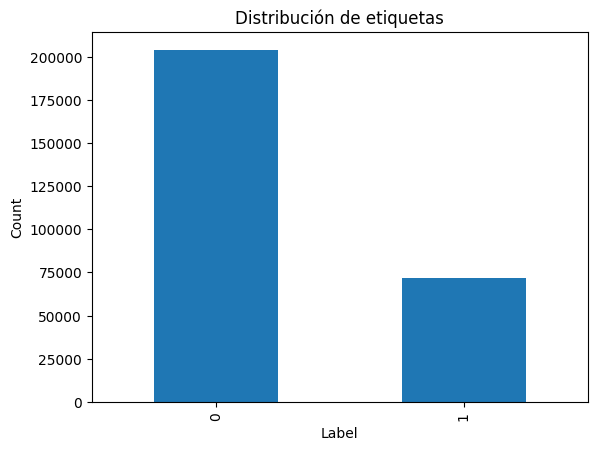

In [45]:
# Ver el conteo de cada etiqueta
label_counts = df_label['label'].value_counts()
print("Distribución de etiquetas:\n", label_counts)

# Calcular el porcentaje de cada etiqueta
label_percentage = df_label['label'].value_counts(normalize=True) * 100
print("Porcentaje de cada etiqueta:\n", label_percentage)

# Opcional: visualizar la distribución
import matplotlib.pyplot as plt

label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribución de etiquetas')
plt.show()

Dado que los datos reflejan si una persona es deudora o no, hemos decidido realizar un tratamiento de datos desbalanceados utilizando **oversampling**. A continuación, exploraremos la mejor manera de aplicarlo.

Primero, dividiremos el conjunto de datos en dos variables: `X` con las características seleccionadas previamente mediante el método RFE, y otra variable `y` que contiene las etiquetas de clase.

Es importante destacar que, como hemos consolidado las filas de cada cliente en una sola, las filas de características y las etiquetas coinciden en su orden y número. Por lo tanto, no es necesario realizar ningún proceso adicional para alinear estas variables.

In [48]:
X = df[['Infraction_CGP', 'Risk_1930', 'Expenditure_JIG', 'Infraction_FMXQ',
       'Base_1165', 'Payment_22507', 'Base_9516', 'Expenditure_FIP',
       'Expenditure_HMO', 'Expenditure_LMSR', 'Base_14808', 'Infraction_ZYW',
       'Infraction_HSSU', 'Infraction_CLH', 'Base_8511', 'Infraction_ZTYG',
       'Infraction_QKZN', 'Infraction_CZE', 'Risk_7095', 'Infraction_JBR',
       'Risk_2102', 'Risk_4247', 'Risk_2380', 'Infraction_MHM', 'Risk_6977',
       'Risk_6178', 'Infraction_WVC', 'Expenditure_UIWS', 'Expenditure_MTRQ',
       'Expenditure_HPM', 'Infraction_LTIS', 'Base_5441', 'Base_67254',
       'Infraction_TPAF', 'Infraction_ZRH', 'Infraction_XEPQ',
       'Infraction_ZMKI', 'Infraction_WVAW', 'Infraction_TFOY',
       'Infraction_WMAQ', 'Base_52892', 'Risk_5270', 'Infraction_YQXM',
       'Infraction_IBJ', 'Infraction_DNOU', 'Infraction_YFSG_CL',
       'Infraction_YFSG_XL', 'Infraction_YFSG_XM', 'Infraction_DQLY_-1',
       'Infraction_DQLY_R']]
X_test = df_test[['Infraction_CGP', 'Risk_1930', 'Expenditure_JIG', 'Infraction_FMXQ',
       'Base_1165', 'Payment_22507', 'Base_9516', 'Expenditure_FIP',
       'Expenditure_HMO', 'Expenditure_LMSR', 'Base_14808', 'Infraction_ZYW',
       'Infraction_HSSU', 'Infraction_CLH', 'Base_8511', 'Infraction_ZTYG',
       'Infraction_QKZN', 'Infraction_CZE', 'Risk_7095', 'Infraction_JBR',
       'Risk_2102', 'Risk_4247', 'Risk_2380', 'Infraction_MHM', 'Risk_6977',
       'Risk_6178', 'Infraction_WVC', 'Expenditure_UIWS', 'Expenditure_MTRQ',
       'Expenditure_HPM', 'Infraction_LTIS', 'Base_5441', 'Base_67254',
       'Infraction_TPAF', 'Infraction_ZRH', 'Infraction_XEPQ',
       'Infraction_ZMKI', 'Infraction_WVAW', 'Infraction_TFOY',
       'Infraction_WMAQ', 'Base_52892', 'Risk_5270', 'Infraction_YQXM',
       'Infraction_IBJ', 'Infraction_DNOU', 'Infraction_YFSG_CL',
       'Infraction_YFSG_XL', 'Infraction_YFSG_XM', 'Infraction_DQLY_-1',
       'Infraction_DQLY_R']]
y = df_label['label']


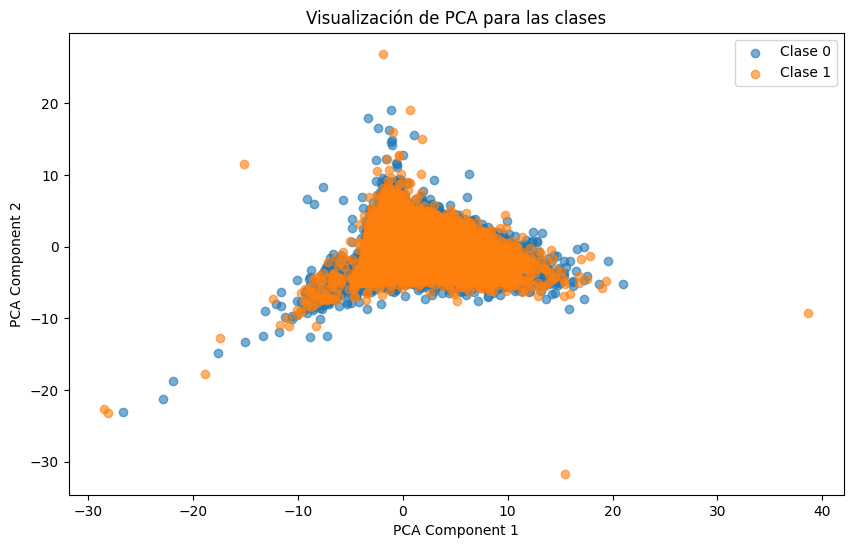

In [47]:
# Aplicamos PCA para reducir el conjunto de datos a 2 componentes principales,
# manteniendo así las dimensiones más representativas de la variabilidad de los datos.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Creamos una visualización en 2D de las dos clases en el nuevo espacio de componentes principales.
# Graficamos los datos transformados, donde cada punto representa una observación en el espacio reducido:
# el primer componente principal se ubica en el eje x y el segundo en el eje y.
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Clase 0', alpha=0.6)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Clase 1', alpha=0.6)

# Añadimos etiquetas a los ejes, un título descriptivo y una leyenda para distinguir las clases.
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualización de PCA para las clases')
plt.legend()
plt.show()


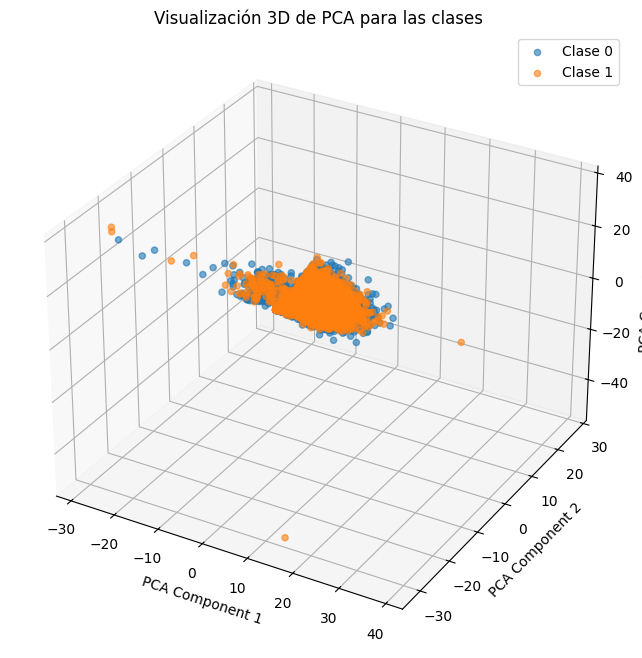

In [ ]:
# Configuramos PCA para reducir el conjunto de datos a 3 componentes principales,
# con el fin de capturar más variabilidad y obtener una representación tridimensional de los datos.
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X)

# Creamos una figura en 3D para visualizar la distribución de las dos clases en el espacio
# definido por los tres componentes principales. Esto ayuda a observar la separación
# o agrupación de las clases en tres dimensiones.
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Graficamos los datos transformados en el espacio tridimensional, donde cada punto
# representa una observación proyectada en los tres primeros componentes principales.
# Se diferencian las dos clases, `Clase 0` y `Clase 1`, con diferentes colores y etiquetas.
ax.scatter(X_pca_3d[y == 0, 0], X_pca_3d[y == 0, 1], X_pca_3d[y == 0, 2], label='Clase 0', alpha=0.6)
ax.scatter(X_pca_3d[y == 1, 0], X_pca_3d[y == 1, 1], X_pca_3d[y == 1, 2], label='Clase 1', alpha=0.6)

# Etiquetamos los ejes con los nombres de los componentes principales y añadimos un título y una leyenda
# para facilitar la interpretación de las clases en el gráfico.
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('Visualización 3D de PCA para las clases')
ax.legend()

plt.show()



Vamos a utilizar **SMOTE (SYNTETIC MINORITY OVER-SAMPLING TECHNIQUE)** para manejar este desbalanceo de los datos, ya que este modelo es muy útil cuando se enfrenta a problemas de una clara subrepresentación de alguna de las partes, en nuestro caso la clara subrepresentacion de los clientes deudores respecto a los no deudores. Es importante tratar este desbalanceo para evitar un sesgo en el posterior entrenamiento del modelo supervisado.

**SMOTE** es una técnica de sobremuestreo que genera nuevas muestras sintéticas para la clase minoritaria, en lugar de simplemente duplicar los datos existentes. Lo hace creando nuevos puntos intermedios entre las observaciones de la clase minoritaria al interpolar valores, lo que mantiene la variabilidad dentro de la clase y reduce el riesgo de sobreajuste.

In [49]:
# Creamos una instancia de SMOTE (Synthetic Minority Over-sampling Technique) para
# realizar sobremuestreo en la clase minoritaria. Usamos random_state=42 para asegurar
# que los resultados sean reproducibles en cada ejecución.
smote = SMOTE(random_state=42)

# Aplicamos SMOTE a las características X y las etiquetas y.
# Esto genera nuevas muestras sintéticas de la clase minoritaria, devolviendo un nuevo
# conjunto de datos balanceado en X_resampled e y_resampled.
X_resampled, y_resampled = smote.fit_resample(X, y)



In [ ]:
# Ver el conteo de cada etiqueta
label_counts = y_resampled.value_counts()
print("Distribución de etiquetas:\n", label_counts)

# Calcular el porcentaje de cada etiqueta
label_percentage = y_resampled.value_counts(normalize=True) * 100
print("Porcentaje de cada etiqueta:\n", label_percentage)

Distribución de etiquetas:
 label
0    203889
1    203889
Name: count, dtype: int64
Porcentaje de cada etiqueta:
 label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [ ]:
X_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407778 entries, 0 to 407777
Data columns (total 50 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Infraction_CGP      407778 non-null  float64
 1   Risk_1930           407778 non-null  float64
 2   Expenditure_JIG     407778 non-null  float64
 3   Infraction_FMXQ     407778 non-null  float64
 4   Base_1165           407778 non-null  float64
 5   Payment_22507       407778 non-null  float64
 6   Base_9516           407778 non-null  float64
 7   Expenditure_FIP     407778 non-null  float64
 8   Expenditure_HMO     407778 non-null  float64
 9   Expenditure_LMSR    407778 non-null  float64
 10  Base_14808          407778 non-null  float64
 11  Infraction_ZYW      407778 non-null  float64
 12  Infraction_HSSU     407778 non-null  float64
 13  Infraction_CLH      407778 non-null  float64
 14  Base_8511           407778 non-null  float64
 15  Infraction_ZTYG     407778 non-nul

Con esto, podemos ver que el desbalanceo ya se ha solucionado, habiendo acabado por completo con el preprocesado necesario para está practica.

## 1.8 Separacion en Entrenamiento y Test

[Volver al Indice](#0-indice)

In [ ]:
X_resampled

Ahora para acabar vamos a realizar la separación en dos conjuntos, el de entrenamiento y el de test, con un 70% y 30% respectivamente. Con esta cantidad para cada cosa creemos que va a ser mas que suficiente para lograr exitosamente ambas labores.

In [ ]:
X_resampled.to_csv('./data/output/clean_train_data.csv', index=False)
X_test.to_csv('./data/output/clean_test_data.csv', index=False)
y.to_csv('./data/output/clean_train_label.csv', index=False)
y_test.to_csv('./data/output/clean_test_label.csv', index=False)


Con esto habriamos concluido con la primera entrega de la práctica

---
# 
Este Práctica se ha realizado por el Grupo_26 -> Pedro Llinas Ferrer y Andrés Benito Llorente